# Block averaging and statistical analysis

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
* [Post-processing](#chapter_2)
    * [Segmentation and averaging](#section_2_1) 
        * [Extract epochs](#sub_section_2_1_1)
        * [Average epochs](#sub_section_2_1_2)
        * [Topographic representation](#sub_section_2_1_3)
    * [Statistical analysis](#section_2_2) 
        * [Check assumptions](#sub_section_2_2_1)
        * [Student's t-test](#sub_section_2_2_2)
        * [ANOVA](#sub_section_2_2_3)
        * [Data Analysis with Bootstrapped ESTimation](#sub_section_2_2_4)


## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
import pylab
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne.preprocessing import ICA, corrmap
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr, probplot, kstest, ttest_ind, ttest_rel
from scipy.signal import wiener
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\3158615722.py:23: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own fucntions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [8]:
filename = 'FTT1.snirf'

In [9]:
# Read snirf data
raw = mne.io.read_raw_snirf(filename, optode_frame='unknown', preload=False, verbose=None)

Loading C:\Users\fabia\fNIRS data analysis\FTT analysis\FTT1\FTT1.snirf


In [10]:
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
raw_intensity = reorder(raw)

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [11]:
# Use self-written function to add info about the subject and the recording
annotations = {"1": "Baseline", "2": "Grasping/Right", "3": "Grasping/Left"}
raw_intensity = add_info(raw_intensity, 'Subject', '1', 26, 'male', 'right', annotations, 10, 60, 10)

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


In [12]:
# Look at characteristics
raw_intensity

<RawSNIRF | FTT1.snirf, 52 x 4394 (852.2 s), ~52 kB, data not loaded>

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


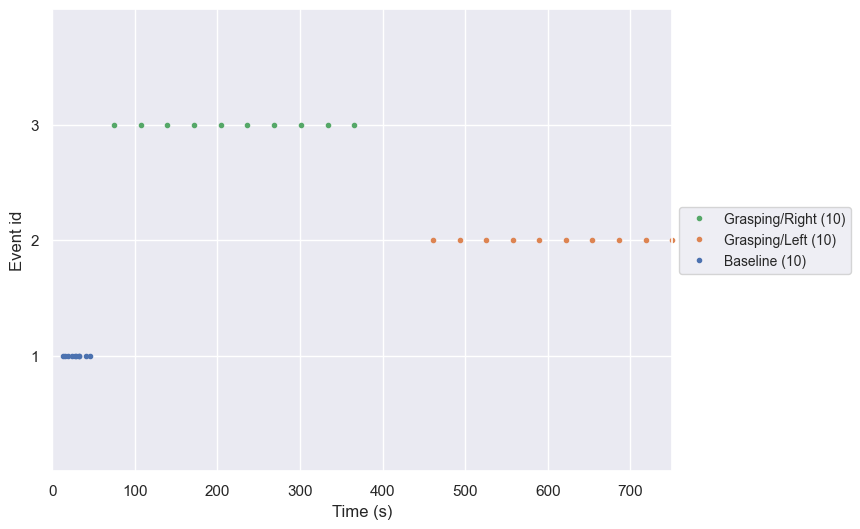

In [13]:
# Look at segments
events, event_dict = mne.events_from_annotations(raw_intensity)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq']);

In [14]:
# As a table
raw_intensity.annotations.to_data_frame()

,onset,duration,description
0,2024-02-15 13:12:49.000,10.0,Baseline
1,2024-02-15 13:12:52.000,10.0,Baseline
2,2024-02-15 13:12:55.000,10.0,Baseline
3,2024-02-15 13:13:00.000,10.0,Baseline
4,2024-02-15 13:13:04.000,10.0,Baseline
5,2024-02-15 13:13:05.000,10.0,Baseline
6,2024-02-15 13:13:08.000,10.0,Baseline
7,2024-02-15 13:13:09.000,10.0,Baseline
8,2024-02-15 13:13:17.000,10.0,Baseline
9,2024-02-15 13:13:22.000,10.0,Baseline


---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- sample frequency = 5.15 Hz
- LPF = 2.58 Hz -  What filter?
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
---

The quality of a fNIRS recording can be assessed by a visual inspection of the signals. On the one hand there can be features present in the signals which indicate a good signal quality, such as certain physiological components, and on the other hand there can be features present which indicate bad signal quality in one or more channels, such as MAs.

##### Validate that the location of sources-detector pairs and channels are in the expected locations

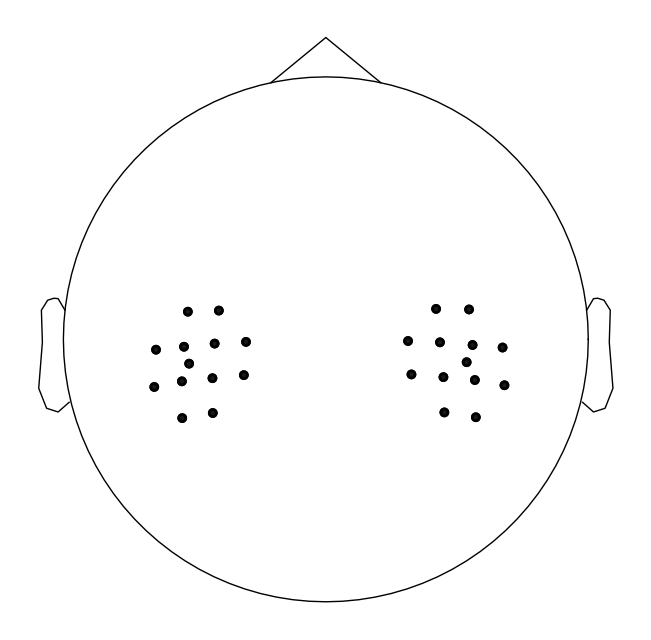

In [15]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensity.plot_sensors();

In [16]:
sns.set_theme()
if plot:
    # Plot channels in 3D
    subjects_dir = mne.datasets.sample.data_path() / "subjects"
    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

    brain = mne.viz.Brain("fsaverage", subjects_dir=subjects_dir, alpha=0.5, cortex="low_contrast")
    brain.add_head()
    
    identity_trans = mne.transforms.Transform("head", "mri") #transformed coord
    brain.add_sensors(raw_intensity.info, trans=identity_trans, fnirs=["channels", "pairs", "sources", "detectors"])

    # Add ROI (Primary motor cortex (precentral gyrus))
    brain.add_label("BA4a", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA4a", hemi = "rh", borders=False, color='blue')
    brain.add_label("BA4p", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA4p", hemi = "rh", borders=False, color='blue')


    brain.show_view(azimuth=90, elevation=90, distance=500)

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

##### Visual inspection of the raw light intensity data

In [17]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensity.plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Physiological components: abc
- Extrinsic components: abc
---

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [18]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_od = optical_density(raw_intensity)

Reading 0 ... 4393  =      0.000 ...   852.242 secs...


In [19]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od.plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Physiological components: abc
- Extrinsic components: abc
---

##### Visual inspection of the haemoglobin concentration

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [20]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemo = beer_lambert_law(raw_od, ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.

In [21]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemo.plot(duration=300, show_scrollbars = True, clipping = None);

In [22]:
# Select long and short channels
min_dist = 0.01
max_dist = 0.045
raw_haemo_full = raw_haemo.copy()
raw_haemo_short =  get_short_channels(raw_haemo, max_dist=max_dist)
raw_haemo =  get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist)

---
> *Remark:*
- abc
---

## Post-processing <a class="anchor" id="chapter_2"></a>

Block averaging is used in block-design experiments, where a stimulus is presented continuously for an extended time interval, followed by an inter-stimulus interval where no stimulus is presented, in which the HR returns to an approximate base level. 

The procedure of block averaging can be divided in three steps:
1. **Segmentation:**  After pre-processing, the continuous fNIRS signal is divided into segments or epochs based on the timing of the task and rest periods.
2. **Averaging:** In block averaging, the noise component of the fNIRS signals is assumed to be a random process with zero mean, and unrelated to the biological signal of interest. Therefore, the corresponding segments from multiple repetitions of the task are averaged together relative to the onset of the stimulus. This averaging process reduces random noise, improving the SNR and thus highlighting the consistent HR associated with the brain activation related to the task.
3. **Analysis:** Finally, the averaged HRF is analyzed to determine the brain’s response to the task. Statistical metrics are used to compare the task and baseline periods, helping to identify significant changes in HbO and HbR.


### Segmentation and averaging <a class="anchor" id="section_2_1"></a>

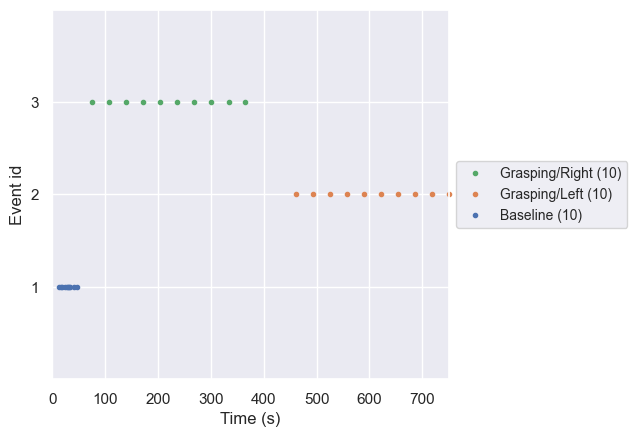

In [23]:
# Visualize events again (see earlier)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq']);

#### Extract epochs <a class="anchor" id="sub_section_2_1_1"></a>

##### Define the range of epochs, the rejection criteria, baseline correction and extract the epochs

In [24]:
# Define rejection criteria
reject_criteria = dict(hbo=80e-6)
# Define start and end of epoch
tmin, tmax = -5, 15

# Create epochs
epochs = mne.Epochs(raw_haemo, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True, reject=reject_criteria, reject_by_annotation=True, baseline=(None, 0))

Not setting metadata
30 matching events found
Setting baseline interval to [-5.0440000000000005, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 104 original time points ...
0 bad epochs dropped


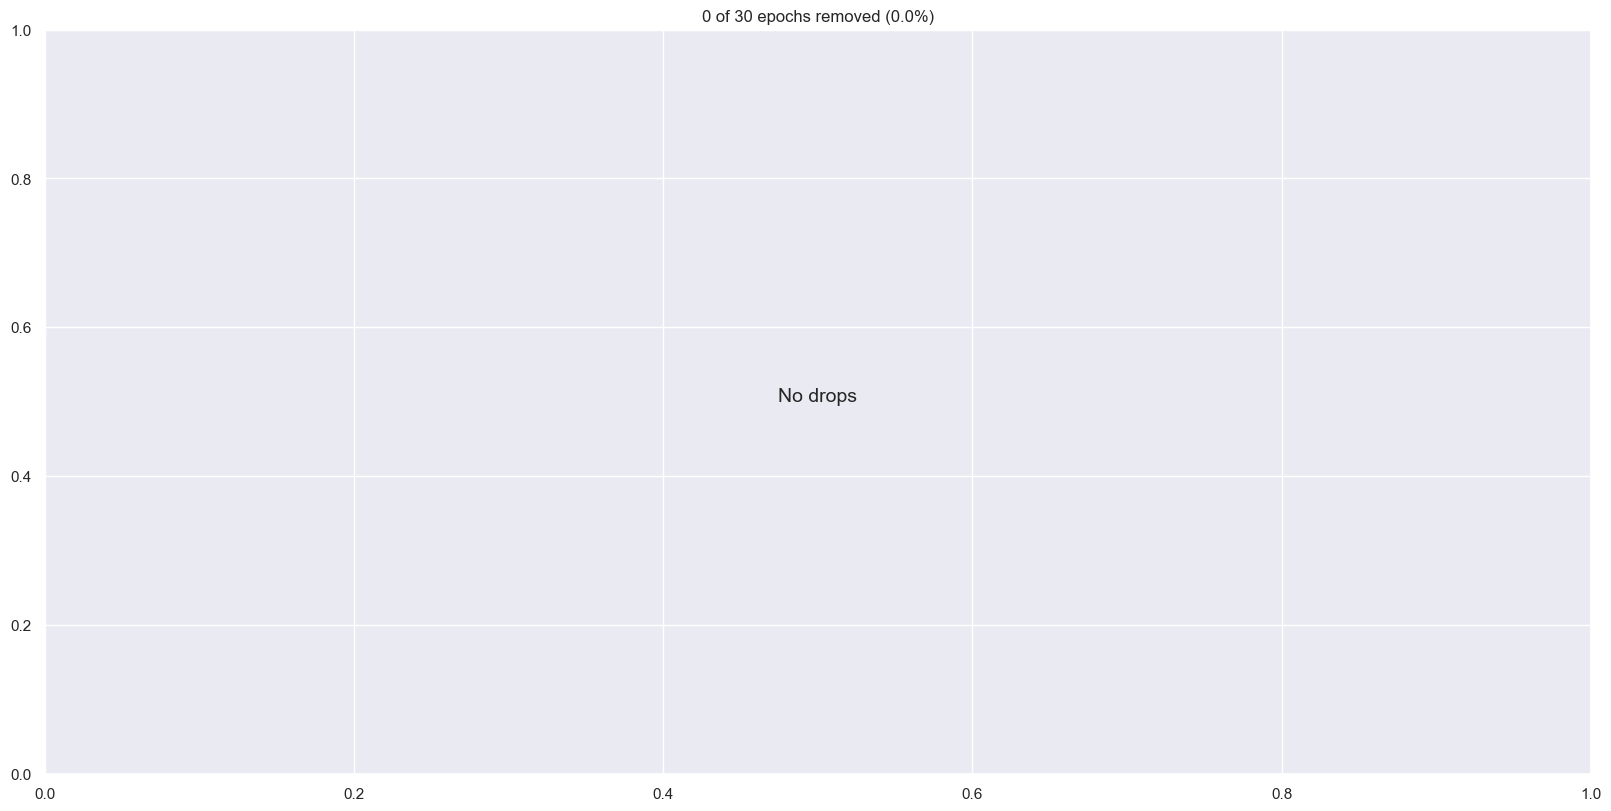

In [25]:
# Visualize rejected epochs
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
epochs.plot_drop_log();

In [26]:
#sample rate not perfectly matched
epochs

Number of events,30
Events,Baseline: 10Grasping/Left: 10Grasping/Right: 10
Time range,-5.044 – 14.938 s
Baseline,-5.044 – 0.000 s


##### Plot the PSD of the epoched data

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\2903422322.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.copy().pick(picks='hbo').compute_psd().plot(average=False, exclude="bads", xscale='log');
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


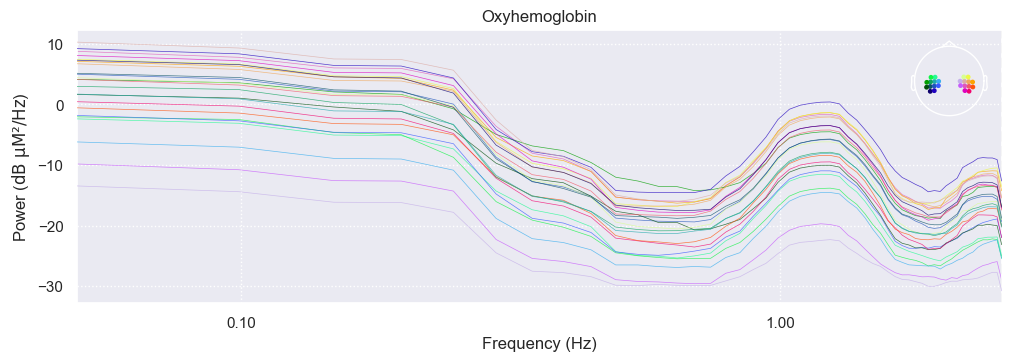

In [27]:
# Hbo
epochs.copy().pick(picks='hbo').compute_psd().plot(average=False, exclude="bads", xscale='log');

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\3103532403.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.copy().pick(picks='hbr').compute_psd().plot(average=False, exclude="bads", xscale='log');
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


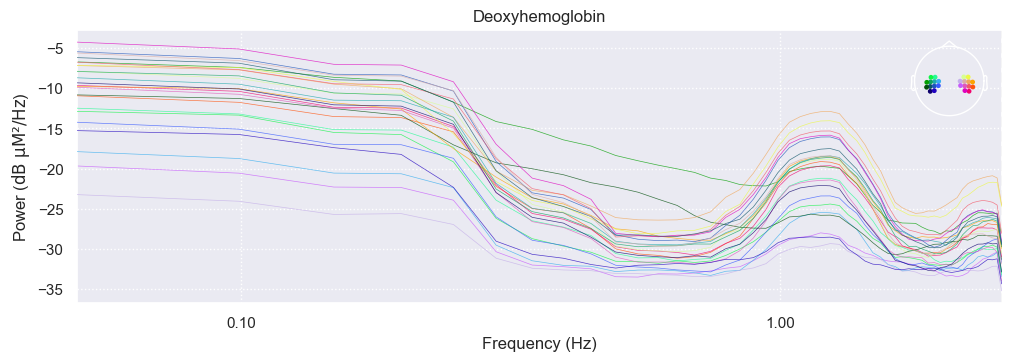

In [28]:
# HbR
epochs.copy().pick(picks='hbr').compute_psd().plot(average=False, exclude="bads", xscale='log');

---
*Remark:*
-  There are no epochs with deviating frequency spectrums
-  or are those two the short channels? No

##### Plot the epoched data

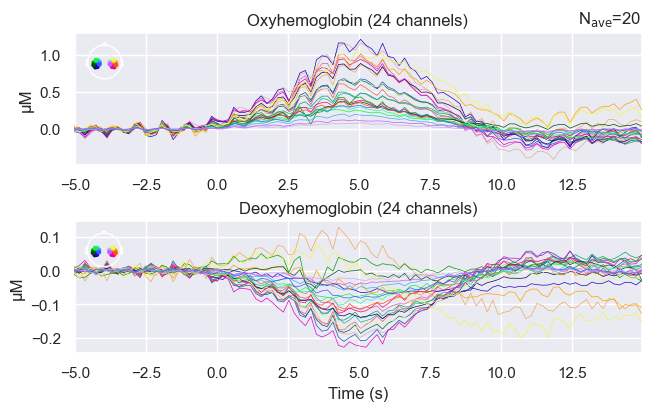

In [29]:
# Hand grasping
%matplotlib inline
epochs['Grasping'].average().plot();

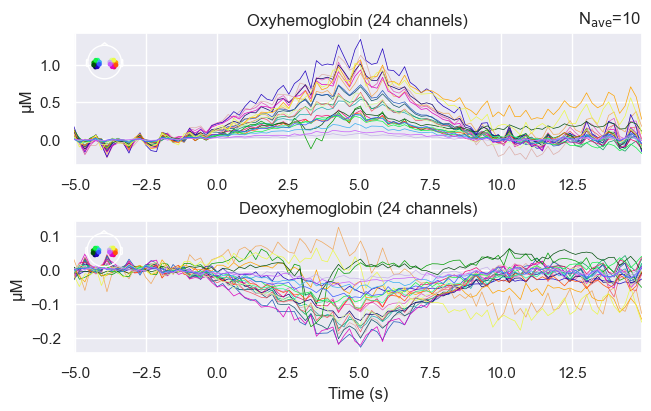

In [30]:
# Right hand grasping
%matplotlib inline
epochs['Grasping/Right'].average().plot();

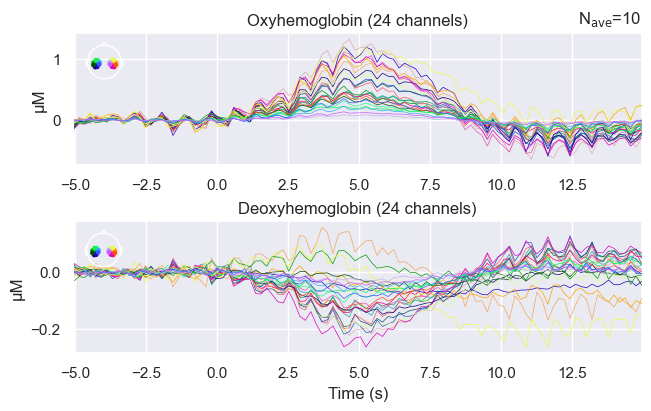

In [31]:
# Left hand grasping
%matplotlib inline
epochs['Grasping/Left'].average().plot();

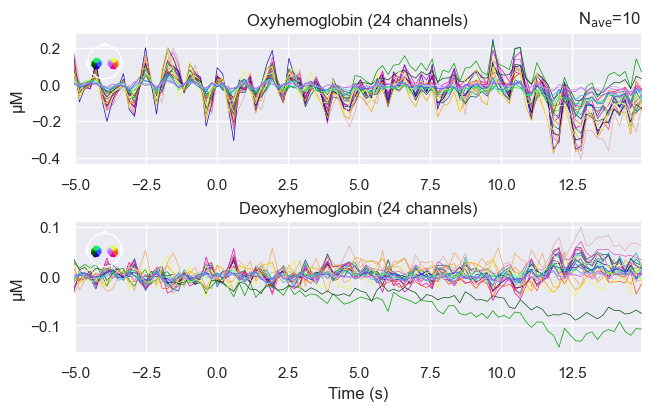

In [32]:
# Control
%matplotlib inline
epochs['Baseline'].average().plot();

---
> *Remark:*
- abc
---

##### View consistency of responses across trials

In [33]:
if plot:
    # Grasping
    %matplotlib qt
    epochs["Grasping"].plot_image(
        combine="mean",
        vmin=-30,
        vmax=30,
        ts_args=dict(ylim=dict(hbo=[-1, 1], hbr=[-0.25, 0.25])))

In [34]:
if plot:
    # Control
    epochs["Baseline"].plot_image(
        combine="mean",
        vmin=-30,
        vmax=30,
        ts_args=dict(ylim=dict(hbo=[-1, 1], hbr=[-0.25, 0.25])))

##### View consistency of responses across channels

In [35]:
if plot:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), layout="constrained")
    clims = dict(hbo=[-1, 1], hbr=[-0.25, 0.25])
    epochs["Baseline"].average().plot_image(axes=axes[:, 0], clim=clims)
    epochs["Grasping"].average().plot_image(axes=axes[:, 1], clim=clims)
    for column, condition in enumerate(["Baseline", "Grasping"]):
        for ax in axes[:, column]:
            ax.set_title("{}: {}".format(condition, ax.get_title()))

---
> *Remark:*
- abc
---

#### Average epochs <a class="anchor" id="sub_section_2_1_2"></a>

##### Plot the PSD of the averaged epoched data

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\4278068405.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.copy().pick(picks='hbo').compute_psd().plot(average=True, exclude="bads", xscale='log');
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


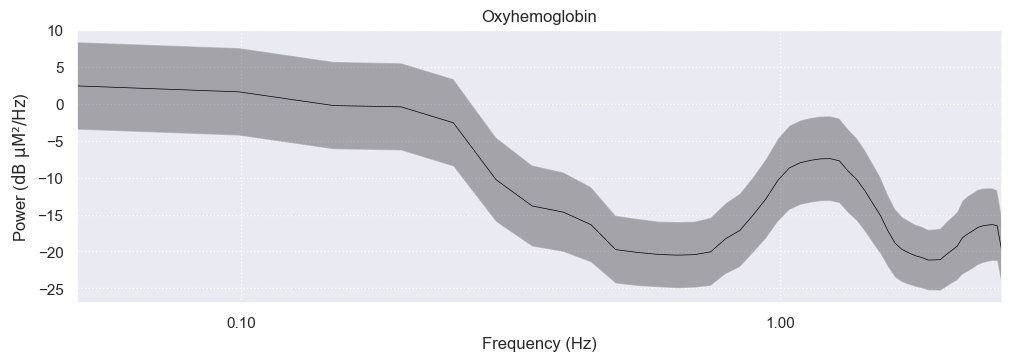

In [36]:
# Hbo
epochs.copy().pick(picks='hbo').compute_psd().plot(average=True, exclude="bads", xscale='log');

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\669459950.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.copy().pick(picks='hbr').compute_psd().plot(average=True, exclude="bads", xscale='log');
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


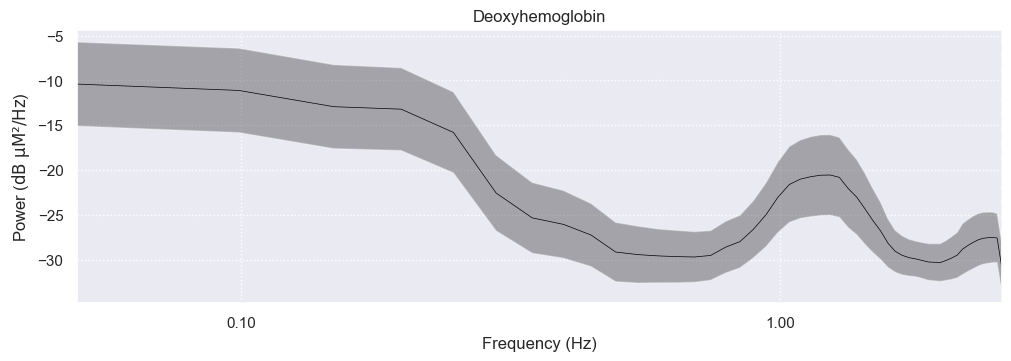

In [37]:
# HbR
epochs.copy().pick(picks='hbr').compute_psd().plot(average=True, exclude="bads", xscale='log');

---
*Remark:*
-  Averaging the epochs removes some of the systemic components that are not time locked to the stimulus

##### Plot standard fNIRS response image

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


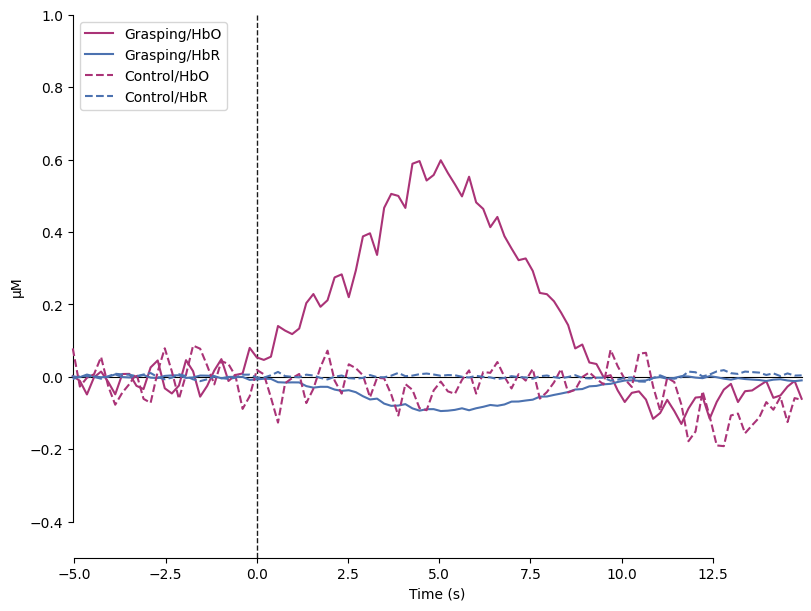

In [38]:
sns.reset_defaults()
evoked_dict = {
    "Grasping/HbO": epochs["Grasping"].average(picks="hbo"),
    "Grasping/HbR": epochs["Grasping"].average(picks="hbr"),
    "Control/HbO": epochs["Baseline"].average(picks="hbo"),
    "Control/HbR": epochs["Baseline"].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

%matplotlib inline

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

fig = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, ylim=dict(hbo=[-0.5, 1]))

---
> *Remark:*
- abc
---

#### Topographic representation <a class="anchor" id="sub_section_2_1_3"></a>

##### Plot hemisphere for each approach

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


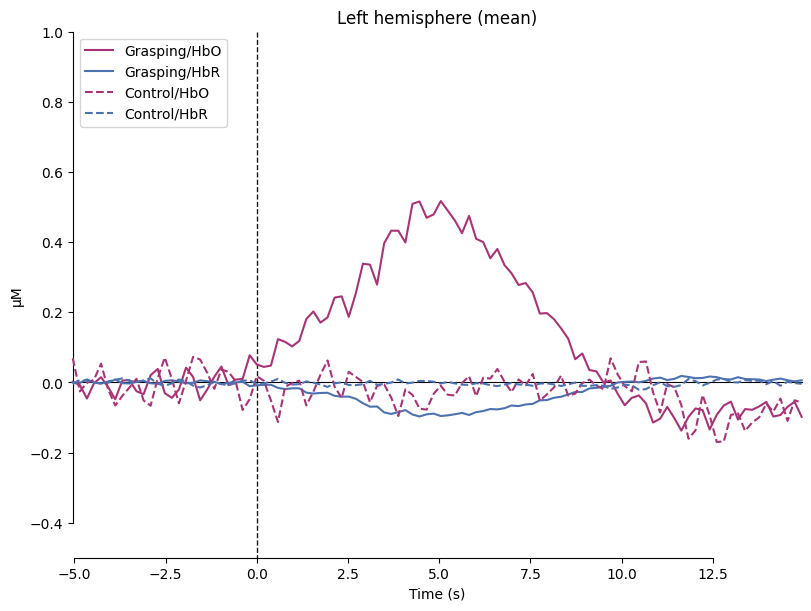

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


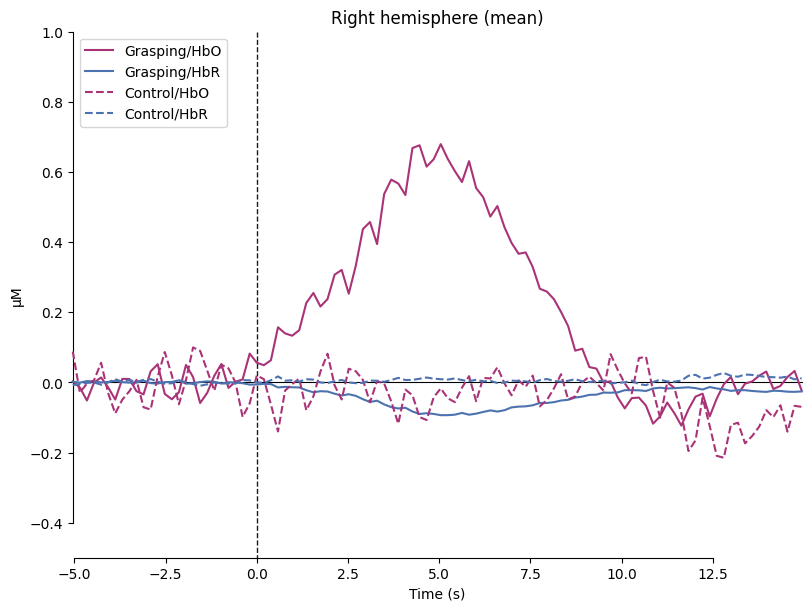

[<Figure size 800x600 with 1 Axes>]

In [39]:
left = [[1, 1], [3, 1], [5, 1], [7, 1], [5, 3], [7, 3], [3, 5], [5, 5], [1, 7], [3, 7], [1, 9], [7, 9]]
right = [[2, 2], [4, 2], [6, 2], [8, 2], [6, 4], [8, 4], [4, 6], [6, 6], [2, 8], [4, 8], [2, 10], [8, 10]]

groups = dict(Left_ROI=picks_pair_to_idx(raw_haemo.copy().pick(picks='hbo'), left, on_missing='warning'),
              Right_ROI=picks_pair_to_idx(raw_haemo.copy().pick(picks='hbo'), right, on_missing='warning'))



mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95, title ='Left hemisphere',
                             picks=groups['Left_ROI'],
                             axes=None, colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-0.5, 1]))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95, title ='Right hemisphere',
                             picks=groups['Right_ROI'],
                             axes=None, colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-0.5, 1]))


---
> *Remark:*
- abc
---

##### Topographic representation of activity

No projector specified for this dataset. Please consider the method self.add_proj.


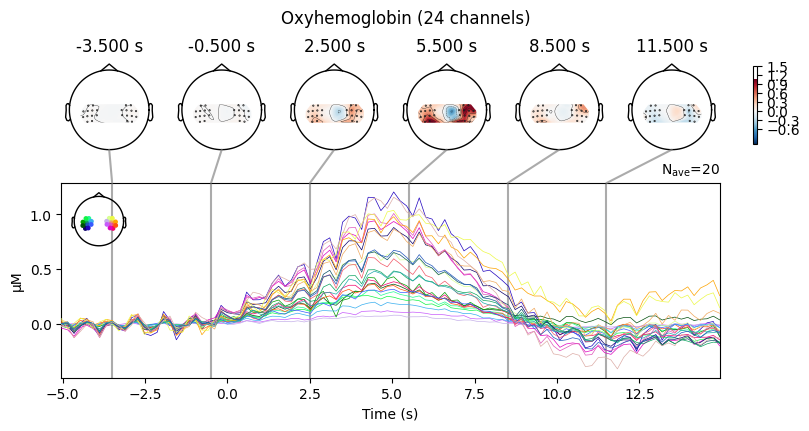

In [40]:
%matplotlib inline
times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate="local")
epochs["Grasping"].average(picks="hbo").plot_joint(
    times=times, topomap_args=topomap_args);

No projector specified for this dataset. Please consider the method self.add_proj.


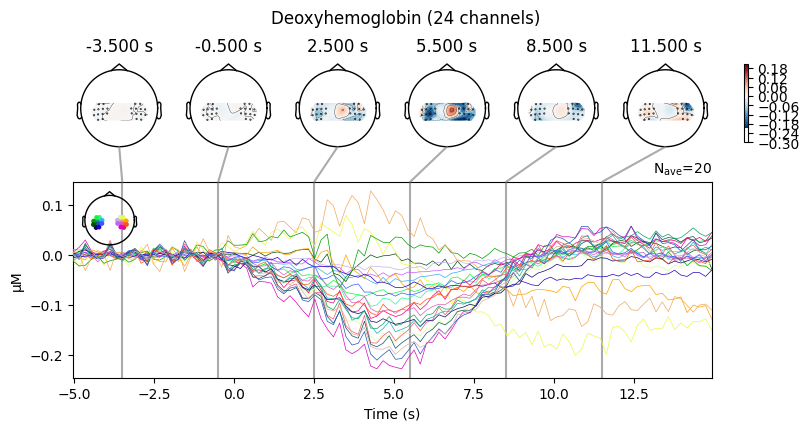

In [41]:
times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate="local")
epochs["Grasping"].average(picks="hbr").plot_joint(
    times=times, topomap_args=topomap_args);

##### Compare tapping of left and right hands

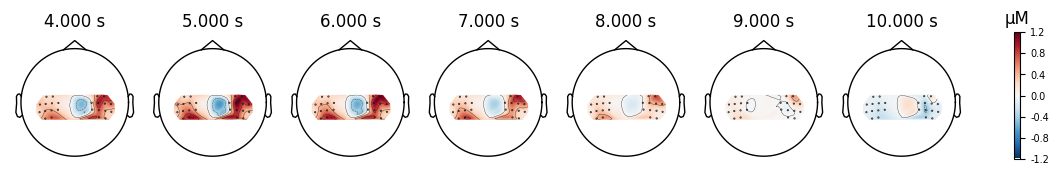

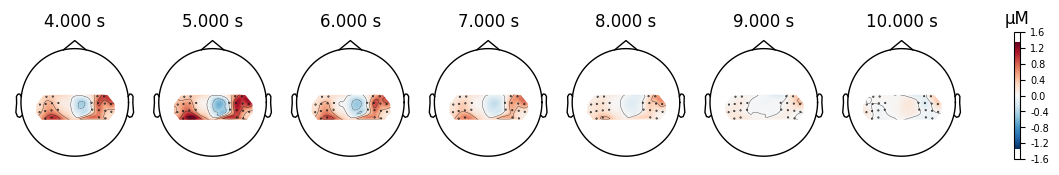

In [42]:
# HbO
times = np.arange(4.0, 11.0, 1.0)
epochs["Grasping/Left"].average(picks="hbo").plot_topomap(times=times, **topomap_args)
epochs["Grasping/Right"].average(picks="hbo").plot_topomap(times=times, **topomap_args);

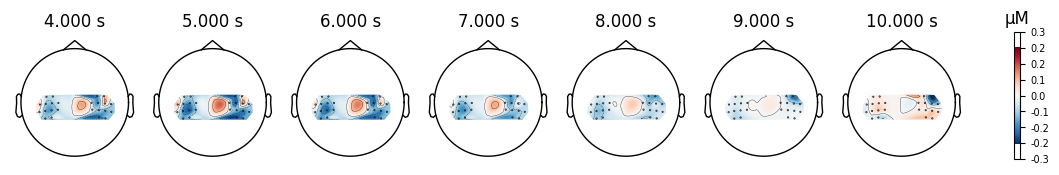

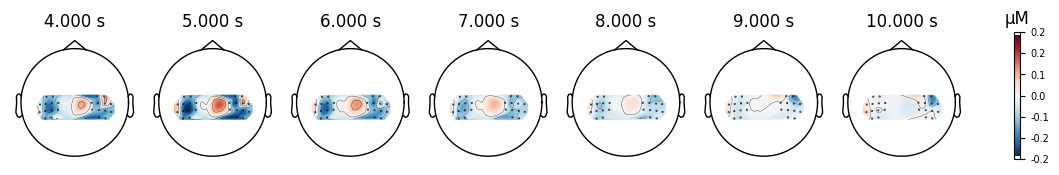

In [43]:
# HbR
times = np.arange(4.0, 11.0, 1.0)
epochs["Grasping/Left"].average(picks="hbr").plot_topomap(times=times, **topomap_args)
epochs["Grasping/Right"].average(picks="hbr").plot_topomap(times=times, **topomap_args);

---
*Remark:*
- Try to plot each hemispere seperate to avoid interpolation


In [44]:
# General remark: ik denk dat de mayer waves echt net tijdens task vielen waardoor er inflated statistics zijn, zie oscillatie in interstimulus interval en in task

### Statistical analysis <a class="anchor" id="section_2_2"></a>

For classical statistical analysis, the time course data are divided into segments corresponding to different conditions, such as baseline and activation periods. The averaged values from these segments (or parts of these segments) are then used for standard statistical analysis. Consequently, block averaging overlooks the detailed time course of the HRF, which is essential for in-depth NIRS analysis. The following sections will discuss four specific parametric statistical metrics (one sample t-test, two sample t-test, paired t-test, and ANOVA) in more detail, based on work by Tak et al. (2014). 

Since these tests are parametric tests, some assumptions that need to be met by the data:
1. **Normality:** The sample data should be drawn from a population that follows an approximately normal distribution. This could be tested with the Kolmogorov-Smirnov test, which has no assumption about the distribution of the data.
2. **Homogeneity of variance:** The sample data should come from a population with uniform variance (F-test).
3. **Independence:** The observations in the sample data should be independent of each other and randomly sampled.
4. **Outliers:** The sample data should be free of extreme outliers.

In [45]:
def extract_data(raw_haemo, epochs, condition, axis = None):
    # Initialize a list to store the results
    results = []
    
    # Fill dataframes by looping (and cropping)
    for i in range(len(epochs[condition])):
        value1 = np.mean(epochs[condition].copy().pick("hbo")[i].get_data(copy = False)[0], axis = axis) * 1e6 # micromol instead of mol

        value2 = np.mean(epochs[condition].copy().pick("hbr")[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        value3 = np.mean(epochs[condition].copy().pick("hbo").crop(tmin=0, tmax=raw_haemo.annotations.duration[0])[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        value4 = np.mean(epochs[condition].copy().pick("hbr").crop(tmin=0, tmax=raw_haemo.annotations.duration[0])[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        # Following a stimulus event, the haemodynamic response typically peaks around 5 seconds after the stimulus onset and returns to the initial level with a delay of approximately 16 seconds (Friston et al., 1998).
        #Take peak value 
    
        value5 = np.mean(epochs[condition].copy().pick("hbo").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        value6 = np.mean(epochs[condition].copy().pick("hbr").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        results.append({"ID": i, "Condition": condition, "Mean_epoch_hbo": value1, "Mean_epoch_hbr": value2, "Mean_task_hbo": value3, "Mean_task_hbr": value4, "Mean_HRF_hbo": value5, "Mean_HRF_hbr": value6 })
    
    # Make dataframe to conduct statistics on
    results = pd.DataFrame(results)

    return results

In [46]:
def extract_channel_data(raw_haemo, epochs, condition, axis = None):
    # Initialize a list to store the results
    results = []
    
    # Fill dataframes by looping (and cropping)
    for i in range(len(epochs[condition])):
        value1 = np.mean(epochs[condition].copy().pick("hbo")[i].get_data(copy = False)[0], axis = axis) * 1e6 # micromol instead of mol

        value2 = np.mean(epochs[condition].copy().pick("hbr")[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        value3 = np.mean(epochs[condition].copy().pick("hbo").crop(tmin=0, tmax=raw_haemo.annotations.duration[0])[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        value4 = np.mean(epochs[condition].copy().pick("hbr").crop(tmin=0, tmax=raw_haemo.annotations.duration[0])[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        # Following a stimulus event, the haemodynamic response typically peaks around 5 seconds after the stimulus onset and returns to the initial level with a delay of approximately 16 seconds (Friston et al., 1998).
        #Take peak value 
    
        value5 = np.mean(epochs[condition].copy().pick("hbo").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        value6 = np.mean(epochs[condition].copy().pick("hbr").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = axis) * 1e6
    
        results.append([list(value1), list(value2), list(value3), list(value4), list(value5), list(value6)])
    
    # Make dataframe to conduct statistics on
    results = np.array(results)

    return results

In [47]:
# Grasping results
df_grasping = extract_data(raw_haemo, epochs, "Grasping")

# Grasping Right results
df_grasping_right = extract_data(raw_haemo, epochs, "Grasping/Right")

# Grasping Left results
df_grasping_left = extract_data(raw_haemo, epochs, "Grasping/Left")

# Control results
df_control = extract_data(raw_haemo, epochs, "Baseline")

In [48]:
results = pd.concat([df_grasping_right, df_grasping_left, df_control])

In [49]:
# 20 epochs for grasping, 10 for control
results

,ID,Condition,Mean_epoch_hbo,Mean_epoch_hbr,Mean_task_hbo,Mean_task_hbr,Mean_HRF_hbo,Mean_HRF_hbr
0,0,Grasping/Right,0.162764,-0.029950,0.348274,-0.054311,0.741553,-0.098562
1,1,Grasping/Right,-0.301768,0.032904,-0.277962,0.030593,-0.374779,0.050450
2,2,Grasping/Right,0.162047,-0.035320,0.222827,-0.046559,0.276352,-0.054851
3,3,Grasping/Right,0.173868,-0.017091,0.255663,-0.028459,0.432939,-0.053607
4,4,Grasping/Right,0.326871,-0.045149,0.602884,-0.086308,0.837260,-0.125943
5,5,Grasping/Right,0.120586,-0.017574,0.282348,-0.040246,0.709057,-0.098292
6,6,Grasping/Right,0.292940,-0.050105,0.391230,-0.065558,0.584531,-0.101410
7,7,Grasping/Right,0.612356,-0.118818,0.974052,-0.187710,1.495926,-0.284993
8,8,Grasping/Right,-0.013234,-0.037350,0.010865,-0.043222,0.138144,-0.064051
9,9,Grasping/Right,0.104275,0.002052,0.225659,-0.019748,0.434188,-0.053364


#### Check assumptions <a class="anchor" id="sub_section_2_2_1"></a>

##### Normality

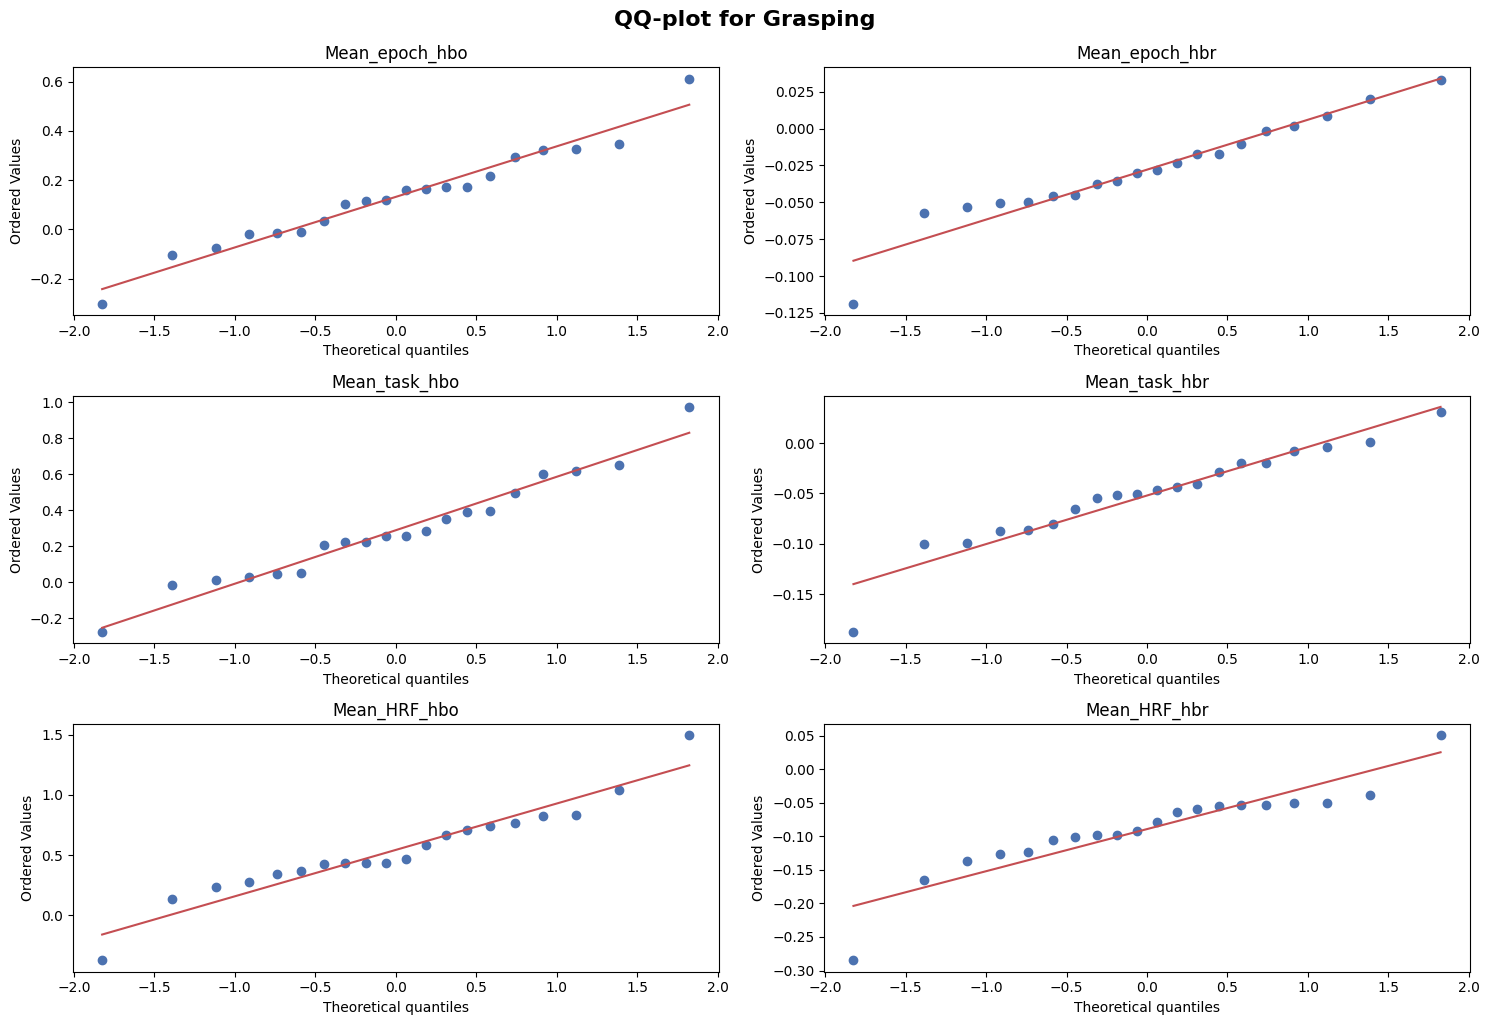

In [50]:
# Visually inspect with QQ-plot
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot each column in a different subplot
for i, column in enumerate(results.columns[2:]):
    probplot(df_grasping[column], dist="norm", plot=axes[i])
    axes[i].set_title(column)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
fig.suptitle('QQ-plot for Grasping', fontsize=16, y = 1.02, fontweight='bold')
plt.show()


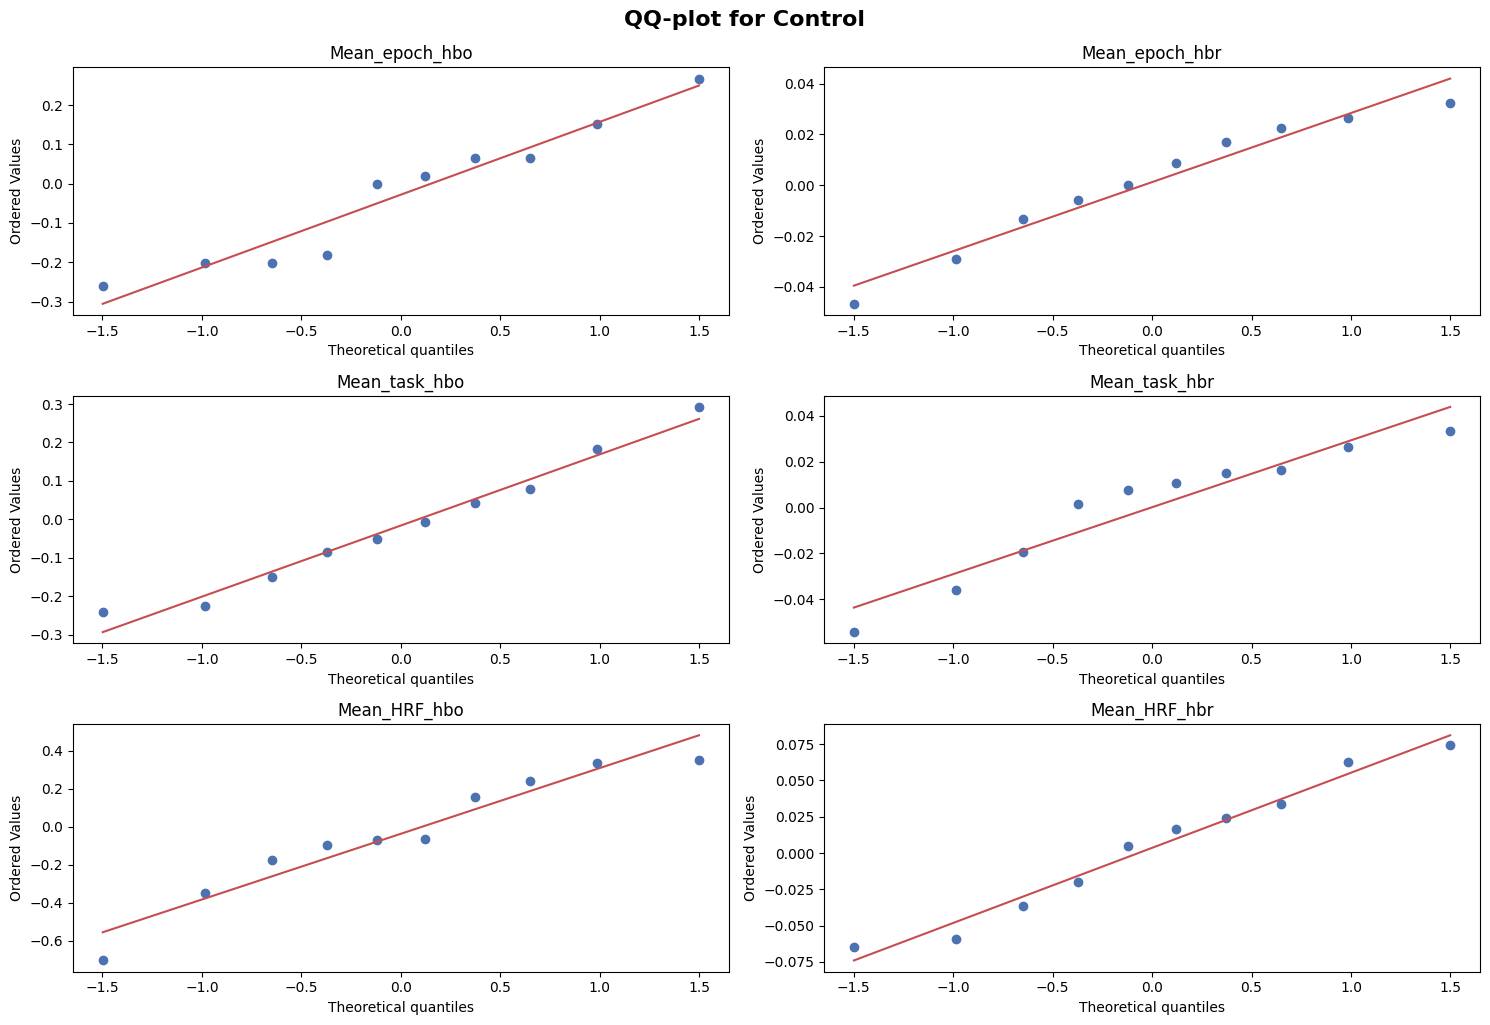

In [51]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot each column in a different subplot
for i, column in enumerate(results.columns[2:]):
    probplot(df_control[column], dist="norm", plot=axes[i])
    axes[i].set_title(column)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
fig.suptitle('QQ-plot for Control', fontsize=16, y = 1.02, fontweight='bold')
plt.show()


---
> *Remark:*
- Vissually everything looks wel
---

In [52]:
# Perform KS test
alpha = 0.05
for column in results.columns[2:]:
    D, p = kstest(df_grasping[column], 'norm')
    print('KS-test for column ' + column + ': statistic = ' + str(D) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: sample data comes from a normal distribution
        print('Not normally distributed')
    else:
        print('Normally distributed')

KS-test for column Mean_epoch_hbo: statistic = 0.40919623996261967, pvalue = 0.0015298908235553688
Not normally distributed
KS-test for column Mean_epoch_hbr: statistic = 0.48687566349639966, pvalue = 6.841976776402886e-05
Not normally distributed
KS-test for column Mean_task_hbo: statistic = 0.4431891353962469, pvalue = 0.00042550000483598804
Not normally distributed
KS-test for column Mean_task_hbr: statistic = 0.4877970628849778, pvalue = 6.56804423926944e-05
Not normally distributed
KS-test for column Mean_HRF_hbo: statistic = 0.5049365778039181, pvalue = 3.016362316114822e-05
Not normally distributed
KS-test for column Mean_HRF_hbr: statistic = 0.4798816985851607, pvalue = 9.30031017943897e-05
Not normally distributed


In [53]:
# Perform KS test
alpha = 0.05
for column in results.columns[2:]:
    D, p = kstest(df_control[column], 'norm')
    print('KS-test for column ' + column + ': statistic = ' + str(D) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: sample data comes from a normal distribution
        print('Not normally distributed')
    else:
        print('Normally distributed')

KS-test for column Mean_epoch_hbo: statistic = 0.39770829699475735, pvalue = 0.061414071604549036
Normally distributed
KS-test for column Mean_epoch_hbr: statistic = 0.48714439580217994, pvalue = 0.01040714566363532
Not normally distributed
KS-test for column Mean_task_hbo: statistic = 0.4051986181519147, pvalue = 0.05378249363412835
Normally distributed
KS-test for column Mean_task_hbr: statistic = 0.4867504822499582, pvalue = 0.010498820675393095
Not normally distributed
KS-test for column Mean_HRF_hbo: statistic = 0.3623643600521089, pvalue = 0.11056319228102218
Normally distributed
KS-test for column Mean_HRF_hbr: statistic = 0.47412376756930547, pvalue = 0.013840440035355783
Not normally distributed


In [54]:
# Perform Shapiro-Wilk test
alpha = 0.05
for column in results.columns[2:]:
    D, p = scipy.stats.shapiro(df_grasping[column])
    print('SW-test for column ' + column + ': statistic = ' + str(D) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: sample data comes from a normal distribution
        print('Not normally distributed')
    else:
        print('Normally distributed')

SW-test for column Mean_epoch_hbo: statistic = 0.974125325679779, pvalue = 0.8384332656860352
Normally distributed
SW-test for column Mean_epoch_hbr: statistic = 0.9488314390182495, pvalue = 0.3496995270252228
Normally distributed
SW-test for column Mean_task_hbo: statistic = 0.9716002345085144, pvalue = 0.7882552146911621
Normally distributed
SW-test for column Mean_task_hbr: statistic = 0.9391355514526367, pvalue = 0.2309146225452423
Normally distributed
SW-test for column Mean_HRF_hbo: statistic = 0.9497859477996826, pvalue = 0.3638516962528229
Normally distributed
SW-test for column Mean_HRF_hbr: statistic = 0.8791670799255371, pvalue = 0.01709318719804287
Not normally distributed


In [55]:
# Perform Shapiro-Wilk test
alpha = 0.05
for column in results.columns[2:]:
    D, p = scipy.stats.shapiro(df_control[column])
    print('SW-test for column ' + column + ': statistic = ' + str(D) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: sample data comes from a normal distribution
        print('Not normally distributed')
    else:
        print('Normally distributed')

SW-test for column Mean_epoch_hbo: statistic = 0.9265799522399902, pvalue = 0.415107399225235
Normally distributed
SW-test for column Mean_epoch_hbr: statistic = 0.9478296637535095, pvalue = 0.6428980231285095
Normally distributed
SW-test for column Mean_task_hbo: statistic = 0.966601550579071, pvalue = 0.8576724529266357
Normally distributed
SW-test for column Mean_task_hbr: statistic = 0.9062904715538025, pvalue = 0.2564700245857239
Normally distributed
SW-test for column Mean_HRF_hbo: statistic = 0.931883692741394, pvalue = 0.4666740894317627
Normally distributed
SW-test for column Mean_HRF_hbr: statistic = 0.9557639360427856, pvalue = 0.7367047667503357
Normally distributed


---
> *Remark:*
- Analytically not very clear
---

##### Homogeneity of variance

In [56]:
# for two different groups
# scipy.stats.levene(sample1, sample2, ...)

##### Outliers

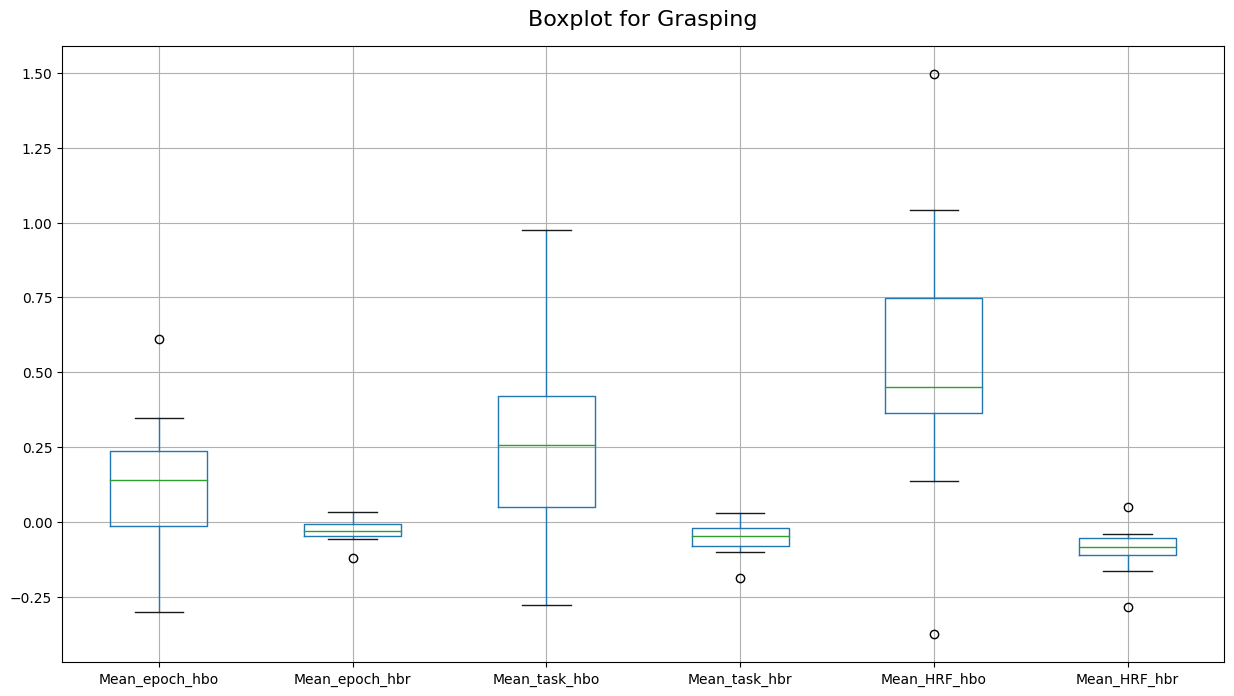

In [57]:
df_grasping.drop('ID', axis=1).boxplot(figsize = (15,8))
plt.title('Boxplot for Grasping', fontsize = 16, y = 1.02);

C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\1382901495.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lim1 = df_grasping.drop('ID', axis=1) > lower_bound
C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\1382901495.py:12: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lim2 = df_grasping.drop('ID', axis=1) < upper_bound


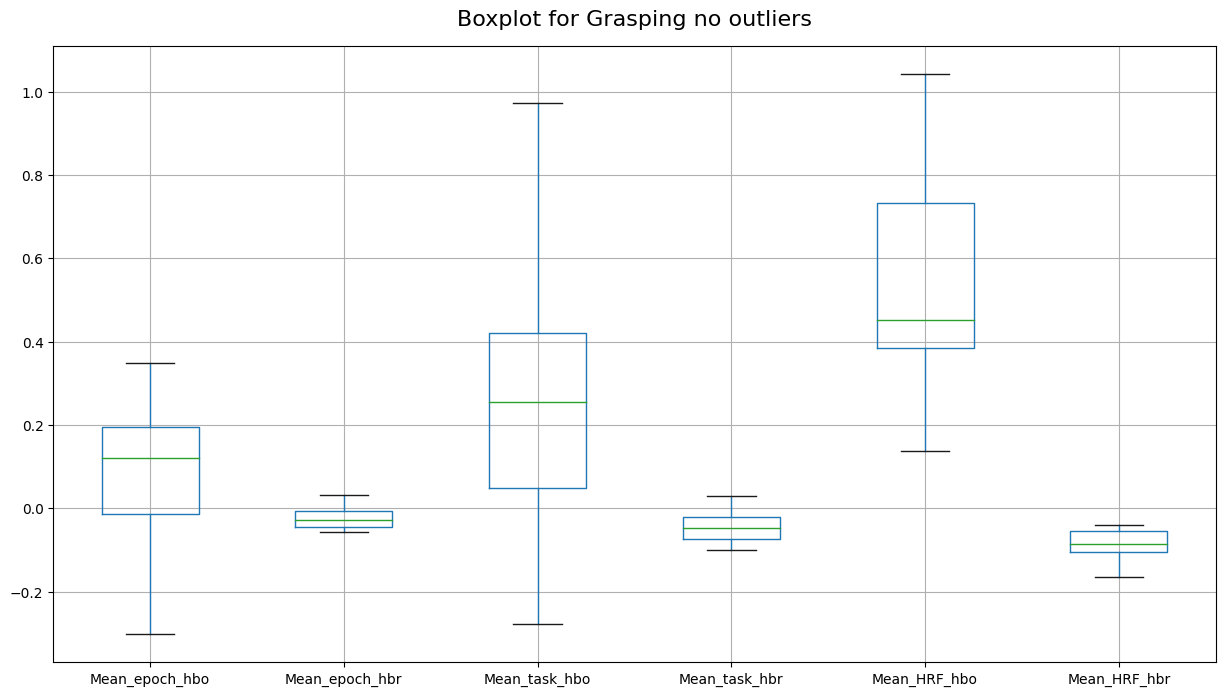

In [58]:
# Remove outliers
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = df_grasping.drop('ID', axis=1).quantile(0.25, numeric_only=True)
Q3 = df_grasping.drop('ID', axis=1).quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lim1 = df_grasping.drop('ID', axis=1) > lower_bound
lim2 = df_grasping.drop('ID', axis=1) < upper_bound

copy_cond = df_grasping['Condition']
copy_ID = df_grasping['ID']

df_grasping_no_outliers = df_grasping.where(lim1*lim2, np.nan)

df_grasping_no_outliers['Condition'] = copy_cond
df_grasping_no_outliers['ID'] = copy_ID

# Plot the boxplot for the cleaned DataFrame
df_grasping_no_outliers.drop('ID', axis=1).boxplot(figsize=(15, 8))
plt.title('Boxplot for Grasping no outliers', fontsize=16, y=1.02)
plt.show()

In [59]:
df_grasping = df_grasping_no_outliers

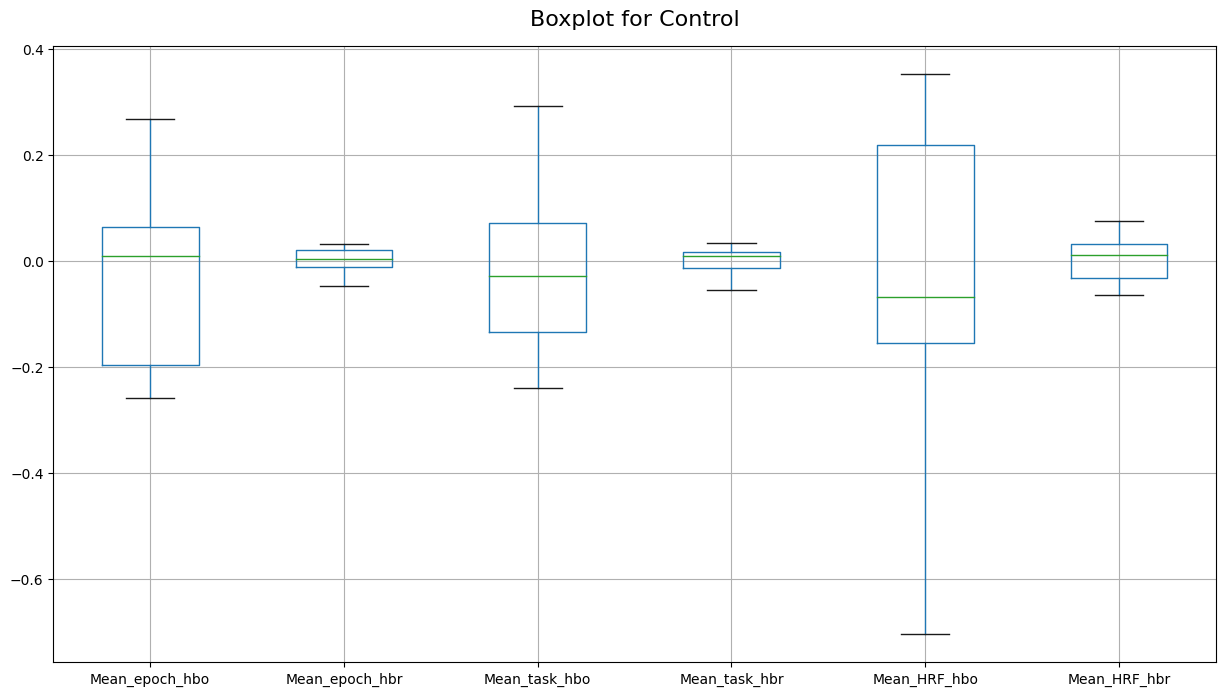

In [60]:
df_control.drop('ID', axis=1).boxplot(figsize = (15,8))
plt.title('Boxplot for Control', fontsize = 16, y = 1.02);

C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\1948915604.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lim1 = df_control.drop('ID', axis=1) > lower_bound
C:\Users\fabia\AppData\Local\Temp\ipykernel_30576\1948915604.py:12: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lim2 = df_control.drop('ID', axis=1) < upper_bound


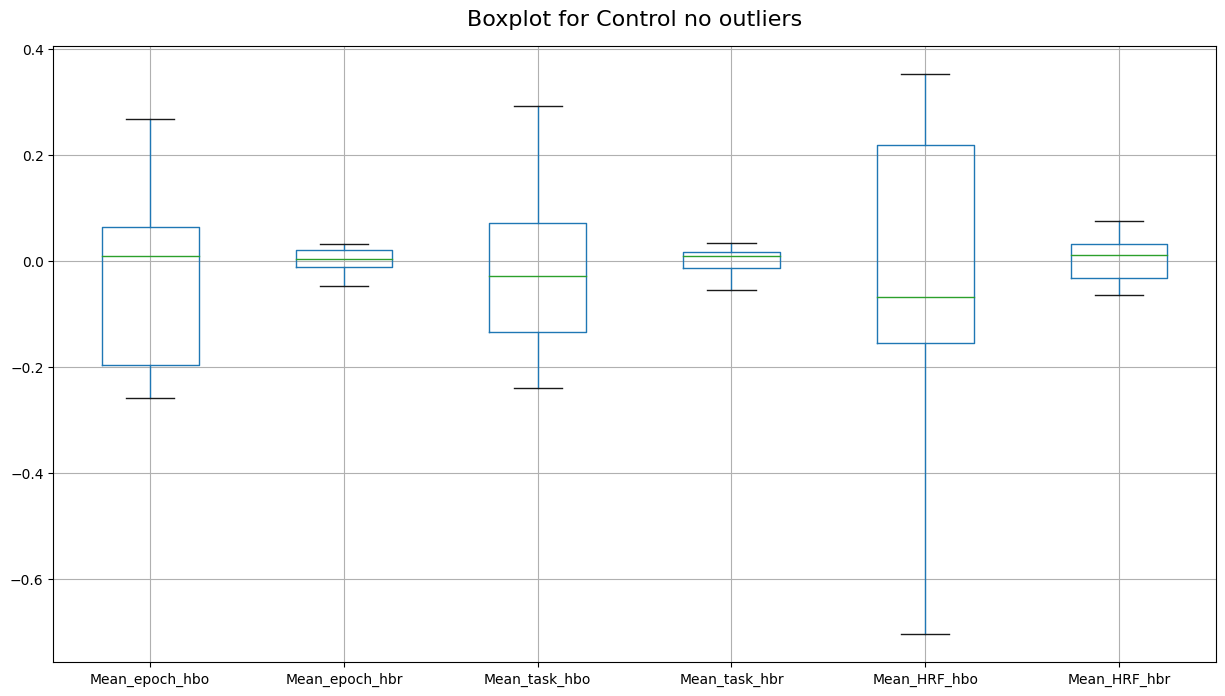

In [61]:
# Remove outliers
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = df_control.drop('ID', axis=1).quantile(0.25, numeric_only=True)
Q3 = df_control.drop('ID', axis=1).quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lim1 = df_control.drop('ID', axis=1) > lower_bound
lim2 = df_control.drop('ID', axis=1) < upper_bound

copy_cond = df_control['Condition']
copy_ID = df_control['ID']

df_control_no_outliers = df_control.where(lim1*lim2, np.nan)

df_control_no_outliers['Condition'] = copy_cond
df_control_no_outliers['ID'] = copy_ID

# Plot the boxplot for the cleaned DataFrame
df_control_no_outliers.drop('ID', axis=1).boxplot(figsize=(15, 8))
plt.title('Boxplot for Control no outliers', fontsize=16, y=1.02)
plt.show()

In [62]:
df_control = df_control_no_outliers

---
> *Remark:*
- Few outliers present
---

#### t-test <a class="anchor" id="sub_section_2_2_2"></a>

##### One-sample t-test

This analysis can be employed to determine whether the average values from the segments corresponding to baseline or activation periods significantly deviate from zero. The assumption is that baseline periods should not differ significantly from zero, while activation periods should, reflecting the presence of the HRF. Therefore, the one-sample t-test can also be used to find significantly activated channels of the montage during the task period.

In [59]:
# Trials with no grasping activity
Grasping = results.query('Condition == "Grasping/Right" or Condition == "Grasping/Left"')
alpha = 0.05
for column in results.columns[1:]:
    print('Mean of ' + column + ' = ' + str(np.mean(Grasping[column])))
    t, p = ttest_1samp(Grasping[column], 0.0)
    print('T-test for column ' + column + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: Mean equal to zero
        print('Mean not equal to zero')
    else:
        print('Mean equal to zero')

Mean of Mean_epoch_hbo = 0.1321105181728465
T-test for column Mean_epoch_hbo: statistic = 2.968800097763771, pvalue = 0.007887641507708742
Mean not equal to zero
Mean of Mean_epoch_hbr = -0.02786284013452281
T-test for column Mean_epoch_hbr: statistic = -3.7438008077665907, pvalue = 0.0013752893733298783
Mean not equal to zero
Mean of Mean_task_hbo = 0.2883299542610147
T-test for column Mean_task_hbo: statistic = 4.48162112128188, pvalue = 0.0002556285963253549
Mean not equal to zero
Mean of Mean_task_hbr = -0.05204534061615722
T-test for column Mean_task_hbr: statistic = -4.881009166456101, pvalue = 0.00010375819226979984
Mean not equal to zero
Mean of Mean_HRF_hbo = 0.5433432538545153
T-test for column Mean_HRF_hbo: statistic = 6.384236367414243, pvalue = 4.009648268420257e-06
Mean not equal to zero
Mean of Mean_HRF_hbr = -0.0893146730332514
T-test for column Mean_HRF_hbr: statistic = -6.16297529256164, pvalue = 6.363882873201029e-06
Mean not equal to zero


In [60]:
# Trials with no grasping activity
Control = results.query('Condition == "Baseline"')
alpha = 0.05
for column in results.columns[1:]:
    print('Mean of ' + column + ' = ' + str(np.mean(Control[column])))
    t, p = ttest_1samp(Control[column], 0.0)
    print('T-test for column ' + column + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: Mean equal to zero
        print('Mean not equal to zero')
    else:
        print('Mean equal to zero')

Mean of Mean_epoch_hbo = -0.06445755778561418
T-test for column Mean_epoch_hbo: statistic = -1.091689158864155, pvalue = 0.3033307965358175
Mean equal to zero
Mean of Mean_epoch_hbr = 0.003411244941981078
T-test for column Mean_epoch_hbr: statistic = 0.37815928416538014, pvalue = 0.7140774262904546
Mean equal to zero
Mean of Mean_task_hbo = -0.11261525473625719
T-test for column Mean_task_hbo: statistic = -1.5977039670918867, pvalue = 0.14457329484865464
Mean equal to zero
Mean of Mean_task_hbr = 0.008921069259413498
T-test for column Mean_task_hbr: statistic = 0.768318740671845, pvalue = 0.4619809495473898
Mean equal to zero
Mean of Mean_HRF_hbo = -0.24128994819496774
T-test for column Mean_HRF_hbo: statistic = -1.9001538349667406, pvalue = 0.08986598136334494
Mean equal to zero
Mean of Mean_HRF_hbr = 0.02696991204791004
T-test for column Mean_HRF_hbr: statistic = 1.4041295230305657, pvalue = 0.1938351253458214
Mean equal to zero


---
> *Remark:*
- For each choice of time segment, the mean value of the grasping activity differs statistically from zero
- For each choice of time segment, the mean value of the baseline activity does not differs statistically from zero
---

In [61]:
# Check for channels with activity

In [63]:
array_grasping = extract_channel_data(raw_haemo, epochs, "Grasping", axis = 1)
pvalues_grasping = np.zeros((24,6))
for i in range(len(raw_haemo.ch_names)//2):
    for j, column in enumerate(results.columns[1:]):
        print('Mean of ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(array_grasping[:,j,i])))
        t, p = ttest_1samp(array_grasping[:,j,i], 0.0)
        print('T-test for column ' + column + ' and channel ' + str(i) + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
        if p < alpha: # Reject H_0: Mean equal to zero
            pvalues_grasping[i,j] = 1
            print('Mean not equal to zero')
        else:
            print('Mean equal to zero')
            pvalues_grasping[i,j] = 0

Mean of Mean_epoch_hbo for channel 0 = 0.08895719472717542
T-test for column Mean_epoch_hbo and channel 0: statistic = 2.591573815588547, pvalue = 0.017904109585620748
Mean not equal to zero
Mean of Mean_epoch_hbr for channel 0 = -0.03366780347574529
T-test for column Mean_epoch_hbr and channel 0: statistic = -3.246319037946681, pvalue = 0.004248720163999532
Mean not equal to zero
Mean of Mean_task_hbo for channel 0 = 0.22144434756277837
T-test for column Mean_task_hbo and channel 0: statistic = 4.4462120443796875, pvalue = 0.00027703477930681066
Mean not equal to zero
Mean of Mean_task_hbr for channel 0 = -0.07429068646612089
T-test for column Mean_task_hbr and channel 0: statistic = -4.960792314626362, pvalue = 8.677937516206011e-05
Mean not equal to zero
Mean of Mean_HRF_hbo for channel 0 = 0.4329200797475356
T-test for column Mean_HRF_hbo and channel 0: statistic = 6.475496082284617, pvalue = 3.3202594347558535e-06
Mean not equal to zero
Mean of Mean_HRF_hbr for channel 0 = -0.1391

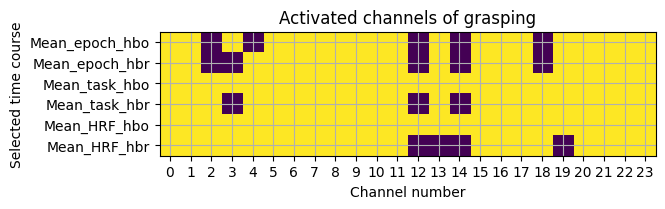

In [64]:
# Yellow =  activated (Mean not equal to zero)
plt.imshow(pvalues_grasping.T)
y_pos = range(len(results.columns[1:]))
x_pos = np.arange(24)
plt.xticks(x_pos)
plt.yticks(y_pos, results.columns[1:], rotation=0)
plt.xlabel('Channel number')
plt.ylabel('Selected time course')
plt.title('Activated channels of grasping')
plt.grid()

---
> *Remark:*
- Most channels have signs of activation
---

In [65]:
array_control = extract_channel_data(raw_haemo, epochs, "Baseline", axis = 1)
pvalues_control = np.zeros((24,6))
for i in range(len(raw_haemo.ch_names)//2):
    for j, column in enumerate(results.columns[1:]):
        print('Mean of ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(array_control[:,j,i])))
        t, p = ttest_1samp(array_control[:,j,i], 0.0)
        print('T-test for column ' + column + ' and channel ' + str(i) + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
        if p < alpha: # Reject H_0: Mean equal to zero
            pvalues_control[i,j] = 1
            print('Mean not equal to zero')
        else:
            print('Mean equal to zero')
            pvalues_control[i,j] = 0

Mean of Mean_epoch_hbo for channel 0 = -0.043040518364149474
T-test for column Mean_epoch_hbo and channel 0: statistic = -1.0452872681677323, pvalue = 0.3231513485947428
Mean equal to zero
Mean of Mean_epoch_hbr for channel 0 = 0.010210172963007545
T-test for column Mean_epoch_hbr and channel 0: statistic = 0.8224045219347408, pvalue = 0.43209499452790157
Mean equal to zero
Mean of Mean_task_hbo for channel 0 = -0.08058324074149255
T-test for column Mean_task_hbo and channel 0: statistic = -1.6984003537024335, pvalue = 0.12365649584876952
Mean equal to zero
Mean of Mean_task_hbr for channel 0 = 0.02154436834584213
T-test for column Mean_task_hbr and channel 0: statistic = 1.5003927154355194, pvalue = 0.16775081366072075
Mean equal to zero
Mean of Mean_HRF_hbo for channel 0 = -0.17573995415431468
T-test for column Mean_HRF_hbo and channel 0: statistic = -2.032124063612038, pvalue = 0.07268454377055387
Mean equal to zero
Mean of Mean_HRF_hbr for channel 0 = 0.049273901055291745
T-test fo

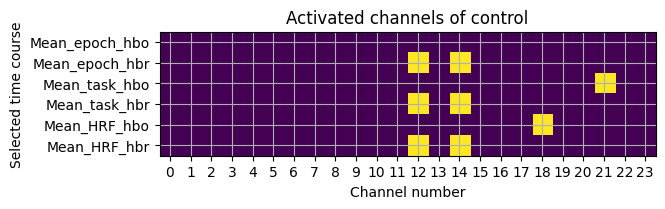

In [66]:
# Yellow =  activated (Mean not equal to zero)
plt.imshow(pvalues_control.T)
y_pos = range(len(results.columns[1:]))
x_pos = np.arange(24)
plt.xticks(x_pos)
plt.yticks(y_pos, results.columns[1:], rotation=0)
plt.xlabel('Channel number')
plt.ylabel('Selected time course')
plt.title('Activated channels of control')
plt.grid()

---
> *Remark:*
- Most channels do not have signs of activation
---

In [67]:
array_grasping_left = extract_channel_data(raw_haemo, epochs, "Grasping/Left", axis = 1)
pvalues_grasping_left = np.zeros((24,6))
for i in range(len(raw_haemo.ch_names)//2):
    for j, column in enumerate(results.columns[1:]):
        print('Mean of ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(array_grasping_left[:,j,i])))
        t, p = ttest_1samp(array_grasping_left[:,j,i], 0.0)
        print('T-test for column ' + column + ' and channel ' + str(i) + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
        if p < alpha: # Reject H_0: Mean equal to zero
            pvalues_grasping_left[i,j] = 1
            print('Mean not equal to zero')
        else:
            print('Mean equal to zero')
            pvalues_grasping_left[i,j] = 0

array_grasping_right = extract_channel_data(raw_haemo, epochs, "Grasping/Right", axis = 1)
pvalues_grasping_right = np.zeros((24,6))
for i in range(len(raw_haemo.ch_names)//2):
    for j, column in enumerate(results.columns[1:]):
        print('Mean of ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(array_grasping_right[:,j,i])))
        t, p = ttest_1samp(array_grasping_right[:,j,i], 0.0)
        print('T-test for column ' + column + ' and channel ' + str(i) + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
        if p < alpha: # Reject H_0: Mean equal to zero
            pvalues_grasping_right[i,j] = 1
            print('Mean not equal to zero')
        else:
            print('Mean equal to zero')
            pvalues_grasping_right[i,j] = 0

Mean of Mean_epoch_hbo for channel 0 = 0.04405351491828785
T-test for column Mean_epoch_hbo and channel 0: statistic = 1.2230255231189675, pvalue = 0.2523774442501174
Mean equal to zero
Mean of Mean_epoch_hbr for channel 0 = -0.019355948660488665
T-test for column Mean_epoch_hbr and channel 0: statistic = -1.7056442188188647, pvalue = 0.12226359613329874
Mean equal to zero
Mean of Mean_task_hbo for channel 0 = 0.18067645231723314
T-test for column Mean_task_hbo and channel 0: statistic = 3.055664931505519, pvalue = 0.013667096572426702
Mean not equal to zero
Mean of Mean_task_hbr for channel 0 = -0.06105413724657558
T-test for column Mean_task_hbr and channel 0: statistic = -3.3047786631173866, pvalue = 0.009159839398085894
Mean not equal to zero
Mean of Mean_HRF_hbo for channel 0 = 0.39830312971329773
T-test for column Mean_HRF_hbo and channel 0: statistic = 6.94021766377159, pvalue = 6.757590779583123e-05
Mean not equal to zero
Mean of Mean_HRF_hbr for channel 0 = -0.1288962984455811

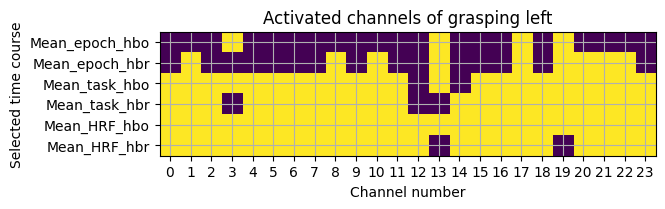

In [68]:
# Yellow =  activated (Mean not equal to zero)
plt.imshow(pvalues_grasping_left.T)
y_pos = range(len(results.columns[1:]))
x_pos = np.arange(24)
plt.xticks(x_pos)
plt.yticks(y_pos, results.columns[1:], rotation=0)
plt.xlabel('Channel number')
plt.ylabel('Selected time course')
plt.title('Activated channels of grasping left')
plt.grid()

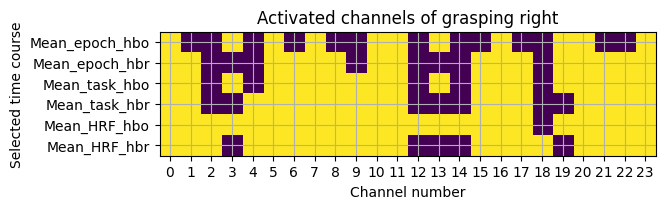

In [69]:
# Yellow =  activated (Mean not equal to zero)
plt.imshow(pvalues_grasping_right.T)
y_pos = range(len(results.columns[1:]))
x_pos = np.arange(24)
plt.xticks(x_pos)
plt.yticks(y_pos, results.columns[1:], rotation=0)
plt.xlabel('Channel number')
plt.ylabel('Selected time course')
plt.title('Activated channels of grasping right')
plt.grid()

In [70]:
# But to compare channels from each hemisphere to each other?
ROI_right = picks_pair_to_idx(raw_haemo.copy().pick(picks='hbo'), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy().pick(picks='hbo'), left, on_missing='warning')
print('Indices right hemisphere: ' + str(ROI_right))
print('Indices left hemisphere: ' + str(ROI_left))

Indices right hemisphere: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
Indices left hemisphere: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]


---
> *Remark:*
- Hoped to see a relation between left/right grasping and channels of right/left hemisphere
---

##### Two-sample t-test

A two-sample t-test enables testing the null hypothesis that the means of two groups, denoted as $y_{l,A}$ for group A and $y_{l,B}$ for group B, are equal. This test can be used to analyze baseline and activation periods by comparing the means of the two groups: one group representing the baseline period and the other representing the activation period. By conducting a two-sample t-test between these two groups, we can assess whether there is a significant difference in means between a control group and an experimental group, helping to identify whether the observed changes in the activation period are statistically significant.

In [71]:
# Compare left vs right hemishere in both right and left activation

In [72]:
array_grasping_right = extract_channel_data(raw_haemo, epochs, "Grasping/Right", axis = 1)
# 10 trials right hand, 3 different time courses looked at x 2 chromophores, 24 channels
print(array_grasping_right.shape)

array_grasping_left = extract_channel_data(raw_haemo, epochs, "Grasping/Left", axis = 1)
# 10 trials left hand, 3 different time courses looked at x 2 chromophores, 24 channels
print(array_grasping_left.shape)

(10, 6, 24)
(10, 6, 24)


In [73]:
array_grasping_right_ROI_right = array_grasping_right[:,:,ROI_right]
array_grasping_right_ROI_left = array_grasping_right[:,:,ROI_left]
array_grasping_left_ROI_right = array_grasping_left[:,:,ROI_right]
array_grasping_left_ROI_left = array_grasping_left[:,:,ROI_left]
# Only 12 channels left
array_grasping_right_ROI_right.shape

(10, 6, 12)

In [74]:
np.mean(array_grasping_right_ROI_right[:,0,:])


0.1850543069805976

In [75]:
# Grasping right
pvalues_grasping_right = np.zeros(6)
for j, column in enumerate(results.columns[1:]):
    print('Mean of ' + column + ' for right hemishpere = ' + str(np.mean(array_grasping_right_ROI_right[:,j,:])))
    print('Mean of ' + column + ' for left hemishpere = ' + str(np.mean(array_grasping_right_ROI_left[:,j,:])))
    t, p = ttest_ind(np.mean(array_grasping_right_ROI_right[:,j,:], axis = 1), np.mean(array_grasping_right_ROI_left[:,j,:], axis = 1))
    print('T-test for column ' + column + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: Means are equal
        pvalues_grasping_right[j] = 1
        print('Means are not equal')
    else:
        print('Means are equal')
        pvalues_grasping_right[j] = 0

Mean of Mean_epoch_hbo for right hemishpere = 0.1850543069805976
Mean of Mean_epoch_hbo for left hemishpere = 0.143086303743093
T-test for column Mean_epoch_hbo: statistic = 0.3957855655253262, pvalue = 0.6969151170004435
Means are equal
Mean of Mean_epoch_hbr for right hemishpere = -0.03440732082003919
Mean of Mean_epoch_hbr for left hemishpere = -0.02887315781092373
T-test for column Mean_epoch_hbr: statistic = -0.3001992137340346, pvalue = 0.7674646219308966
Means are equal
Mean of Mean_task_hbo for right hemishpere = 0.32998380448718667
Mean of Mean_task_hbo for left hemishpere = 0.2771841285346811
T-test for column Mean_task_hbo: statistic = 0.35494700464555845, pvalue = 0.7267541824124888
Means are equal
Mean of Mean_task_hbr for right hemishpere = -0.05255645116562253
Mean of Mean_task_hbr for left hemishpere = -0.0557488835845013
T-test for column Mean_task_hbr: statistic = 0.12198449952072833, pvalue = 0.9042628485073451
Means are equal
Mean of Mean_HRF_hbo for right hemishper

In [76]:
# Grasping left
pvalues_grasping_left = np.zeros((24,6))
for j, column in enumerate(results.columns[1:]):
    print('Mean of ' + column + ' for right hemishpere = ' + str(np.mean(array_grasping_left_ROI_right[:,j,:])))
    print('Mean of ' + column + ' for left hemishpere = ' + str(np.mean(array_grasping_left_ROI_left[:,j,:])))
    t, p = ttest_ind(np.mean(array_grasping_left_ROI_right[:,j,:], axis = 1), np.mean(array_grasping_left_ROI_left[:,j,:], axis = 1))
    print('T-test for column ' + column + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: Means are equal
        pvalues_grasping_left[i,j] = 1
        print('Means are not equal')
    else:
        print('Means are equal')
        pvalues_grasping_left[i,j] = 0

Mean of Mean_epoch_hbo for right hemishpere = 0.13020092597814054
Mean of Mean_epoch_hbo for left hemishpere = 0.07010053598955471
T-test for column Mean_epoch_hbo: statistic = 0.8123771379302277, pvalue = 0.42718933108499735
Means are equal
Mean of Mean_epoch_hbr for right hemishpere = -0.029271087990342132
Mean of Mean_epoch_hbr for left hemishpere = -0.018899793916786183
T-test for column Mean_epoch_hbr: statistic = -0.8106621107274498, pvalue = 0.42814857268143225
Means are equal
Mean of Mean_task_hbo for right hemishpere = 0.32508900058017326
Mean of Mean_task_hbo for left hemishpere = 0.22106288344201758
T-test for column Mean_task_hbo: statistic = 0.8965553189323555, pvalue = 0.3817907446573531
Means are equal
Mean of Mean_task_hbr for right hemishpere = -0.05274266695755337
Mean of Mean_task_hbr for left hemishpere = -0.047133360756951674
T-test for column Mean_task_hbr: statistic = -0.30082327161478795, pvalue = 0.7669963603305496
Means are equal
Mean of Mean_HRF_hbo for right

---
> *Remark:*
- No differences between hemisphere?
---

##### Paired t-test

Finally, the paired t-test is used for when each participant is measured (with respect to the same outcome variable) in both experimental conditions. In the case of a FTT, each person’s brain activity is measured in two conditions: with hand motion, and without hand motion. Therefore, each participant appears in both groups. As a result, the test can assess whether there is a significant difference in means between the baseline and activation periods, helping to identify whether the observed changes in the activation period are statistically significant.

In [77]:
# Trials with left grasping activity vs baseline
Grasping_left = results.query('Condition == "Grasping/Left"')
alpha = 0.05
for column in results.columns[1:]:
    print('Mean of ' + column + ' for grasping left = ' + str(np.mean(Grasping_left[column])))
    print('Mean of ' + column + ' for control = ' + str(np.mean(Control[column])))
    t, p = ttest_rel(Grasping_left[column], Control[column])
    print('T-test for column ' + column + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: Means are equal
        print('Means are not equal')
    else:
        print('Means are equal')

Mean of Mean_epoch_hbo for grasping left = 0.1001507309838476
Mean of Mean_epoch_hbo for control = -0.06445755778561418
T-test for column Mean_epoch_hbo: statistic = 2.0833940893554073, pvalue = 0.06689609546763993
Means are equal
Mean of Mean_epoch_hbr for grasping left = -0.024085440953564158
Mean of Mean_epoch_hbr for control = 0.003411244941981078
T-test for column Mean_epoch_hbr: statistic = -2.073029427658062, pvalue = 0.06802933169110856
Means are equal
Mean of Mean_task_hbo for grasping left = 0.2730759420110954
Mean of Mean_task_hbo for control = -0.11261525473625719
T-test for column Mean_task_hbo: statistic = 3.6860146028279996, pvalue = 0.00502835220850232
Means are not equal
Mean of Mean_task_hbr for grasping left = -0.04993801385725253
Mean of Mean_task_hbr for control = 0.008921069259413498
T-test for column Mean_task_hbr: statistic = -3.317486255257282, pvalue = 0.008976189499583873
Means are not equal
Mean of Mean_HRF_hbo for grasping left = 0.5591694106441565
Mean of 

In [78]:
# Trials with left grasping activity vs baseline
Grasping_right = results.query('Condition == "Grasping/Right"')
alpha = 0.05
for column in results.columns[1:]:
    print('Mean of ' + column + ' for grasping right = ' + str(np.mean(Grasping_right[column])))
    print('Mean of ' + column + ' for control = ' + str(np.mean(Control[column])))
    t, p = ttest_rel(Grasping_right[column], Control[column])
    print('T-test for column ' + column + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
    if p < alpha: # Reject H_0: Means are equal
        print('Means are not equal')
    else:
        print('Means are equal')

Mean of Mean_epoch_hbo for grasping right = 0.1640703053618453
Mean of Mean_epoch_hbo for control = -0.06445755778561418
T-test for column Mean_epoch_hbo: statistic = 2.279258314601958, pvalue = 0.04862142276327526
Means are not equal
Mean of Mean_epoch_hbr for grasping right = -0.03164023931548145
Mean of Mean_epoch_hbr for control = 0.003411244941981078
T-test for column Mean_epoch_hbr: statistic = -2.1894008892595647, pvalue = 0.056305210510627327
Means are equal
Mean of Mean_task_hbo for grasping right = 0.3035839665109339
Mean of Mean_task_hbo for control = -0.11261525473625719
T-test for column Mean_task_hbo: statistic = 3.0109133371281835, pvalue = 0.014694084191736104
Means are not equal
Mean of Mean_task_hbr for grasping right = -0.054152667375061914
Mean of Mean_task_hbr for control = 0.008921069259413498
T-test for column Mean_task_hbr: statistic = -2.689803843012973, pvalue = 0.024804485770381947
Means are not equal
Mean of Mean_HRF_hbo for grasping right = 0.52751709706487

---
> *Remark:*
- abc
---

In [79]:
control = extract_channel_data(raw_haemo, epochs, "Baseline", axis = 1)
pvalues_grasping_left = np.zeros((24,6))
for i in range(len(raw_haemo.ch_names)//2):
    for j, column in enumerate(results.columns[1:]):
        print('Mean of ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(array_grasping_left[:,j,i])))
        print('Mean of control ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(control[:,j,i])))
        t, p = ttest_rel(array_grasping_left[:,j,i], control[:,j,i])
        print('T-test for column ' + column + ' and channel ' + str(i) + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
        if p < alpha: # Reject H_0: Means are equal
            pvalues_grasping_left[i,j] = 1
            print('Means are not equal')
        else:
            print('Means are equal')
            pvalues_grasping_left[i,j] = 0

array_grasping_right = extract_channel_data(raw_haemo, epochs, "Grasping/Right", axis = 1)
pvalues_grasping_right = np.zeros((24,6))
for i in range(len(raw_haemo.ch_names)//2):
    for j, column in enumerate(results.columns[1:]):
        print('Mean of ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(array_grasping_right[:,j,i])))
        print('Mean of control ' + column + ' for channel ' + str(i) + ' = ' + str(np.mean(control[:,j,i])))
        t, p = ttest_rel(array_grasping_right[:,j,i], control[:,j,i])
        print('T-test for column ' + column + ' and channel ' + str(i) + ': statistic = ' + str(t) + ', pvalue = ' + str(p))
        if p < alpha: # Reject H_0: Means are equal
            pvalues_grasping_right[i,j] = 1
            print('Means are not equal')
        else:
            print('Means are equal')
            pvalues_grasping_right[i,j] = 0

Mean of Mean_epoch_hbo for channel 0 = 0.04405351491828785
Mean of control Mean_epoch_hbo for channel 0 = -0.043040518364149474
T-test for column Mean_epoch_hbo and channel 0: statistic = 1.4340183365323262, pvalue = 0.18538312774056645
Means are equal
Mean of Mean_epoch_hbr for channel 0 = -0.019355948660488665
Mean of control Mean_epoch_hbr for channel 0 = 0.010210172963007545
T-test for column Mean_epoch_hbr and channel 0: statistic = -1.54899485483745, pvalue = 0.15579188927594573
Means are equal
Mean of Mean_task_hbo for channel 0 = 0.18067645231723314
Mean of control Mean_task_hbo for channel 0 = -0.08058324074149255
T-test for column Mean_task_hbo and channel 0: statistic = 3.124793107664456, pvalue = 0.012223828711526908
Means are not equal
Mean of Mean_task_hbr for channel 0 = -0.06105413724657558
Mean of control Mean_task_hbr for channel 0 = 0.02154436834584213
T-test for column Mean_task_hbr and channel 0: statistic = -3.1257519090573207, pvalue = 0.012204956195933899
Means 

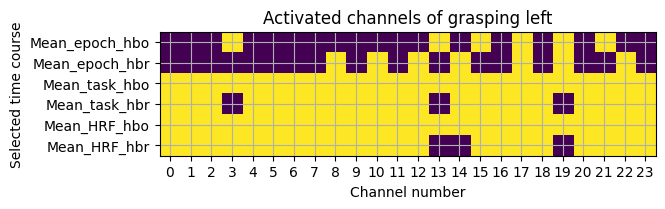

In [80]:
# Yellow =  activated (Mean not equal to zero)
plt.imshow(pvalues_grasping_left.T)
y_pos = range(len(results.columns[1:]))
x_pos = np.arange(24)
plt.xticks(x_pos)
plt.yticks(y_pos, results.columns[1:], rotation=0)
plt.xlabel('Channel number')
plt.ylabel('Selected time course')
plt.title('Activated channels of grasping left')
plt.grid()

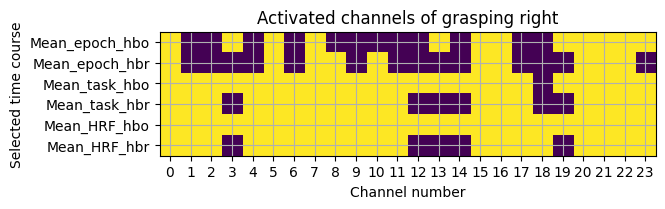

In [81]:
# Yellow =  activated (Mean not equal to zero)
plt.imshow(pvalues_grasping_right.T)
y_pos = range(len(results.columns[1:]))
x_pos = np.arange(24)
plt.xticks(x_pos)
plt.yticks(y_pos, results.columns[1:], rotation=0)
plt.xlabel('Channel number')
plt.ylabel('Selected time course')
plt.title('Activated channels of grasping right')
plt.grid()

#### ANOVA <a class="anchor" id="sub_section_2_2_3"></a>

In [82]:
# Try in python it self
from statsmodels.stats.anova import AnovaRM 

In [83]:
conditions = ['Grasping/Left', 'Grasping/Right', 'Baseline']

In [84]:
ROI_left

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

In [85]:
def data_ANOVA_2WRM(raw_haemo, epochs, conditions, ROI_left, ROI_right):
    # Initialize a list to store the results
    results = []
    
    # Fill dataframes by looping (and cropping)
    for condition in conditions:
        for i in range(len(epochs[condition])): 
            values_ch_hbo = np.mean(epochs[condition].copy().pick("hbo").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = 1) * 1e6
            value_ROI_left_hbo = np.mean(values_ch_hbo[ROI_left])
            value_ROI_right_hbo = np.mean(values_ch_hbo[ROI_right])
            
            values_ch_hbr = np.mean(epochs[condition].copy().pick("hbr").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = 1) * 1e6
            value_ROI_left_hbr = np.mean(values_ch_hbr[ROI_left])
            value_ROI_right_hbr = np.mean(values_ch_hbr[ROI_right])

            if condition == 'Baseline':
                cond = 'Control'
            elif condition == 'Grasping/Left':
                cond = 'left'
            else:
                cond = 'right'
            
            results.append({"Epoch": i, "Condition": cond, "Hemisphere": 'left', "Mean_HRF_hbo": value_ROI_left_hbo, "Mean_HRF_hbr": value_ROI_left_hbr})
            results.append({"Epoch": i , "Condition": cond, "Hemisphere": 'right', "Mean_HRF_hbo": value_ROI_right_hbo, "Mean_HRF_hbr": value_ROI_right_hbr})

            
            
    # Make dataframe to conduct statistics on
    results = pd.DataFrame(results)

    return results

In [86]:
data = data_ANOVA_2WRM(raw_haemo, epochs, conditions, ROI_left, ROI_right)
data

,Epoch,Condition,Hemisphere,Mean_HRF_hbo,Mean_HRF_hbr
0,0,left,left,0.288888,-0.069428
1,0,left,right,0.572297,-0.086762
2,1,left,left,0.782570,-0.137622
3,1,left,right,1.301808,-0.192888
4,2,left,left,0.072342,-0.019405
5,2,left,right,0.405389,-0.058884
6,3,left,left,0.746656,-0.130593
7,3,left,right,0.909103,-0.116843
8,4,left,left,0.547154,-0.103632
9,4,left,right,0.786100,-0.108392


In [87]:
# DV = Mean_HRF_hbo
# IV1 = Hemisphere (left, right)
# IV2 = Condition (left tapping, right tappping, control)
subject = 'Epoch' # (Only 1 present here)
depvar = 'Mean_HRF_hbo'
IV1 = 'Hemisphere'
IV2 = 'Condition'

# 2 x 3 Two-way RM ANOVA
model = AnovaRM(data, depvar, subject, within = [IV1, IV2])
result = model.fit()

In [88]:
print(result)

                      Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
Hemisphere           17.8000 1.0000  9.0000 0.0022
Condition            11.0379 2.0000 18.0000 0.0007
Hemisphere:Condition 11.7641 2.0000 18.0000 0.0005



In [89]:
# DV = Mean_HRF_hbr
# IV1 = Hemisphere (left, right)
# IV2 = Condition (left tapping, right tappping, control)
subject = 'Epoch' # (Only 1 present here)
depvar = 'Mean_HRF_hbr'
IV1 = 'Hemisphere'
IV2 = 'Condition'

# 2 x 3 Two-way RM ANOVA
model2 = AnovaRM(data, depvar, subject, within = [IV1, IV2])
result2 = model2.fit()

In [90]:
print(result2)

                      Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
Hemisphere            0.3813 1.0000  9.0000 0.5522
Condition             8.9045 2.0000 18.0000 0.0020
Hemisphere:Condition  0.8785 2.0000 18.0000 0.4325



In [91]:
# data.to_csv('2W_RM_ANOVA.csv')

In [92]:
# Make new dataframe with right strcuture for SPSS analysis
def data_for_SPSS(raw_haemo, epochs, conditions, ROI_left, ROI_right):
    # Initialize a list to store the results
    results = []
    
    # Fill dataframes by looping (and cropping)
    
    for i in range(len(epochs[conditions[0]])): 
        values = np.zeros((2,len(conditions)))
        conds = []
        for j, condition in enumerate(conditions):
            values_ch = np.mean(epochs[condition].copy().pick("hbo").crop(tmin=4, tmax=6)[i].get_data(copy = False)[0], axis = 1) * 1e6
            value_ROI_left = np.mean(values_ch[ROI_left])
            value_ROI_right = np.mean(values_ch[ROI_right])
            
            values[0,j] = value_ROI_left
            values[1,j] = value_ROI_right

            if condition == 'Baseline':
                cond = '_control'
            elif condition == 'Grasping/Left':
                cond = '_left'
            else:
                cond = '_right'
            conds.append(cond)
        values = values.flatten()
        header = ['L' + c for c in conds] + ['R' + c for c in conds] 

        results.append({'Epoch': i, header[0] : values[0], header[1] : values[1], header[2] : values[2], header[3] : values[3], header[4] : values[4], header[5] : values[5]})
            
            
    # Make dataframe to conduct statistics on
    results = pd.DataFrame(results)

    return results

In [93]:
data_SPSS = data_for_SPSS(raw_haemo, epochs, conditions, ROI_left, ROI_right)

In [94]:
# data_SPSS.to_csv('data_SPSS.csv')

In [95]:
# Import csv file in SPSS

##### Assumptions for ANOVA
1. The dependent variable must be measured on a continuous scale; haemoglobin concentration meets this criterion.
2. The two within-subjects factors should include at least two categorical, related groups or matched pairs. This means that the same subjects should appear in both groups; the hemisphere and condition factors fulfill this requirement.
3. There should be no significant outliers in any combination of the related groups; this needs to be assessed for each dataset.
4. The distribution of the dependent variable within each combination of related groups should be approximately normal; tests such as the Kolmogorov-Smirnov test can be used to verify this.
5. The variances in each group should be roughly equal; this assumption can be checked with Levene's test.
6. Sphericity, which means the variances of the differences between all combinations of related groups must be equal; this can be tested using Mauchly's test of sphericity.

In [96]:
# Each row should be a person?

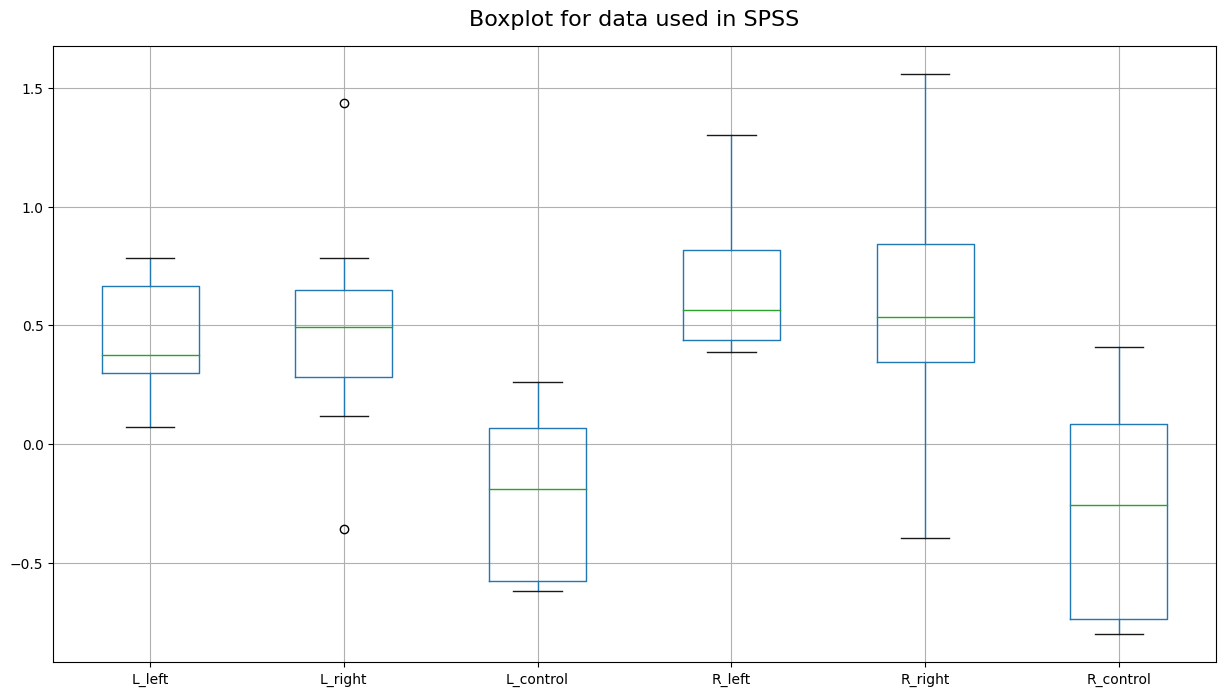

In [97]:
# Check for outliers
data_SPSS[['L_left', 'L_right', 'L_control', 'R_left', 'R_right', 'R_control']].boxplot(figsize=(15, 8))
plt.title('Boxplot for data used in SPSS', fontsize=16, y=1.02)
plt.show()

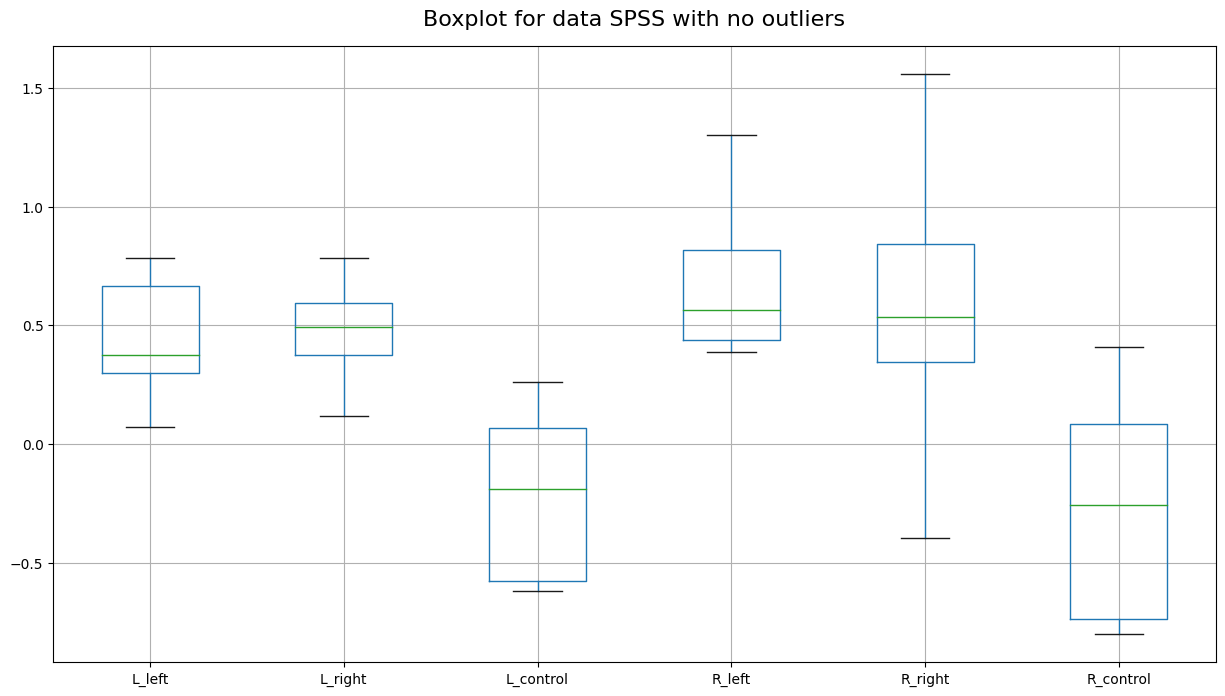

In [98]:
# Remove outliers
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = data_SPSS[['L_left', 'L_right', 'L_control', 'R_left', 'R_right', 'R_control']].quantile(0.25, numeric_only=True)
Q3 = data_SPSS[['L_left', 'L_right', 'L_control', 'R_left', 'R_right', 'R_control']].quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lim1 = data_SPSS[['L_left', 'L_right', 'L_control', 'R_left', 'R_right', 'R_control']] > lower_bound
lim2 = data_SPSS[['L_left', 'L_right', 'L_control', 'R_left', 'R_right', 'R_control']] < upper_bound


copy_epoch = data_SPSS['Epoch']

data_SPSS_no_outliers = data_SPSS.where(lim1*lim2, np.nan)

data_SPSS_no_outliers['Epoch'] = copy_epoch

# Plot the boxplot for the cleaned DataFrame
data_SPSS_no_outliers[['L_left', 'L_right', 'L_control', 'R_left', 'R_right', 'R_control']].boxplot(figsize=(15, 8))
plt.title('Boxplot for data SPSS with no outliers', fontsize=16, y=1.02)
plt.show()

In [99]:
data_SPSS_no_outliers

,Epoch,L_left,L_right,L_control,R_left,R_right,R_control
0,0,0.288888,0.677605,0.263994,0.572297,0.805501,0.407385
1,1,0.782570,NaN,-0.102841,1.301808,-0.392150,-0.180799
2,2,0.072342,0.234511,0.091956,0.405389,0.318192,0.098167
3,3,0.746656,0.436393,0.162096,0.909103,0.429485,0.263149
4,4,0.547154,0.783193,-0.471988,0.786100,0.891328,-0.590254
5,5,0.306255,0.566259,-0.608893,0.559264,0.851854,-0.798268
6,6,0.707003,0.546592,-0.006391,0.829206,0.622470,0.048492
7,7,0.299508,NaN,-0.608309,0.391911,1.556628,-0.784853
8,8,0.393910,0.120031,-0.615043,0.542356,0.156256,-0.787682
9,9,0.354895,0.420905,-0.274019,0.386774,0.447472,-0.331699


#### Data Analysis with Bootstrapped ESTimation <a class="anchor" id="sub_section_2_2_4"></a>

In [63]:
# https://acclab.github.io/DABEST-python/
analysis_of_results = dabest.load(results, idx=("Baseline", "Grasping/Right", "Grasping/Left"), paired = 'baseline', x="Condition", y="Mean_HRF_hbo", id_col="ID")

In [64]:
analysis_of_results

DABEST v2024.03.29
                  
Good evening!
The current time is Thu Jun 20 18:14:15 2024.

Paired effect size(s) for repeated measures against baseline 
with 95% confidence intervals will be computed for:
1. Grasping/Right minus Baseline
2. Grasping/Left minus Baseline

5000 resamples will be used to generate the effect size bootstraps.

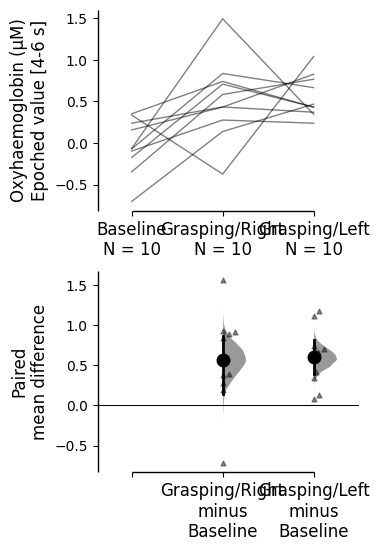

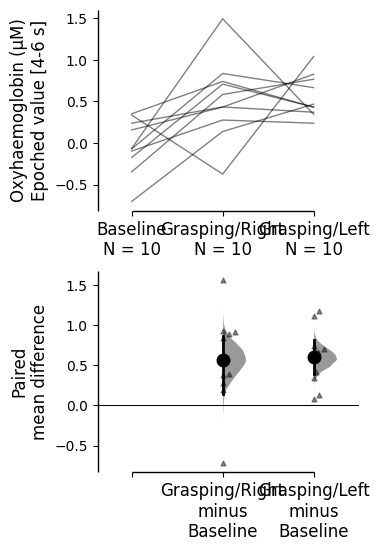

In [65]:
analysis_of_results.mean_diff.plot(swarm_label="Oxyhaemoglobin (µM)\nEpoched value [4-6 s]");analysis_of_results.mean_diff.plot(swarm_label="Oxyhaemoglobin (µM)\nEpoched value [4-6 s]");

In [66]:
analysis_of_results.mean_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Baseline,Grasping/Right,10,10,mean difference,baseline,0.564912,95,0.136121,0.868938,0.019,0.019531,5.0,0.016666,-2.933346
1,Baseline,Grasping/Left,10,10,mean difference,baseline,0.596564,95,0.387298,0.820168,0.000,0.001953,0.0,0.000632,-5.114884


---
> *Remark:*
- Both means differ statistically from baseline
---